In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

A search has been initiated within the folder named 'Dataset'.
There are 896 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 3200 images in the Non_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.
The search has been completed.


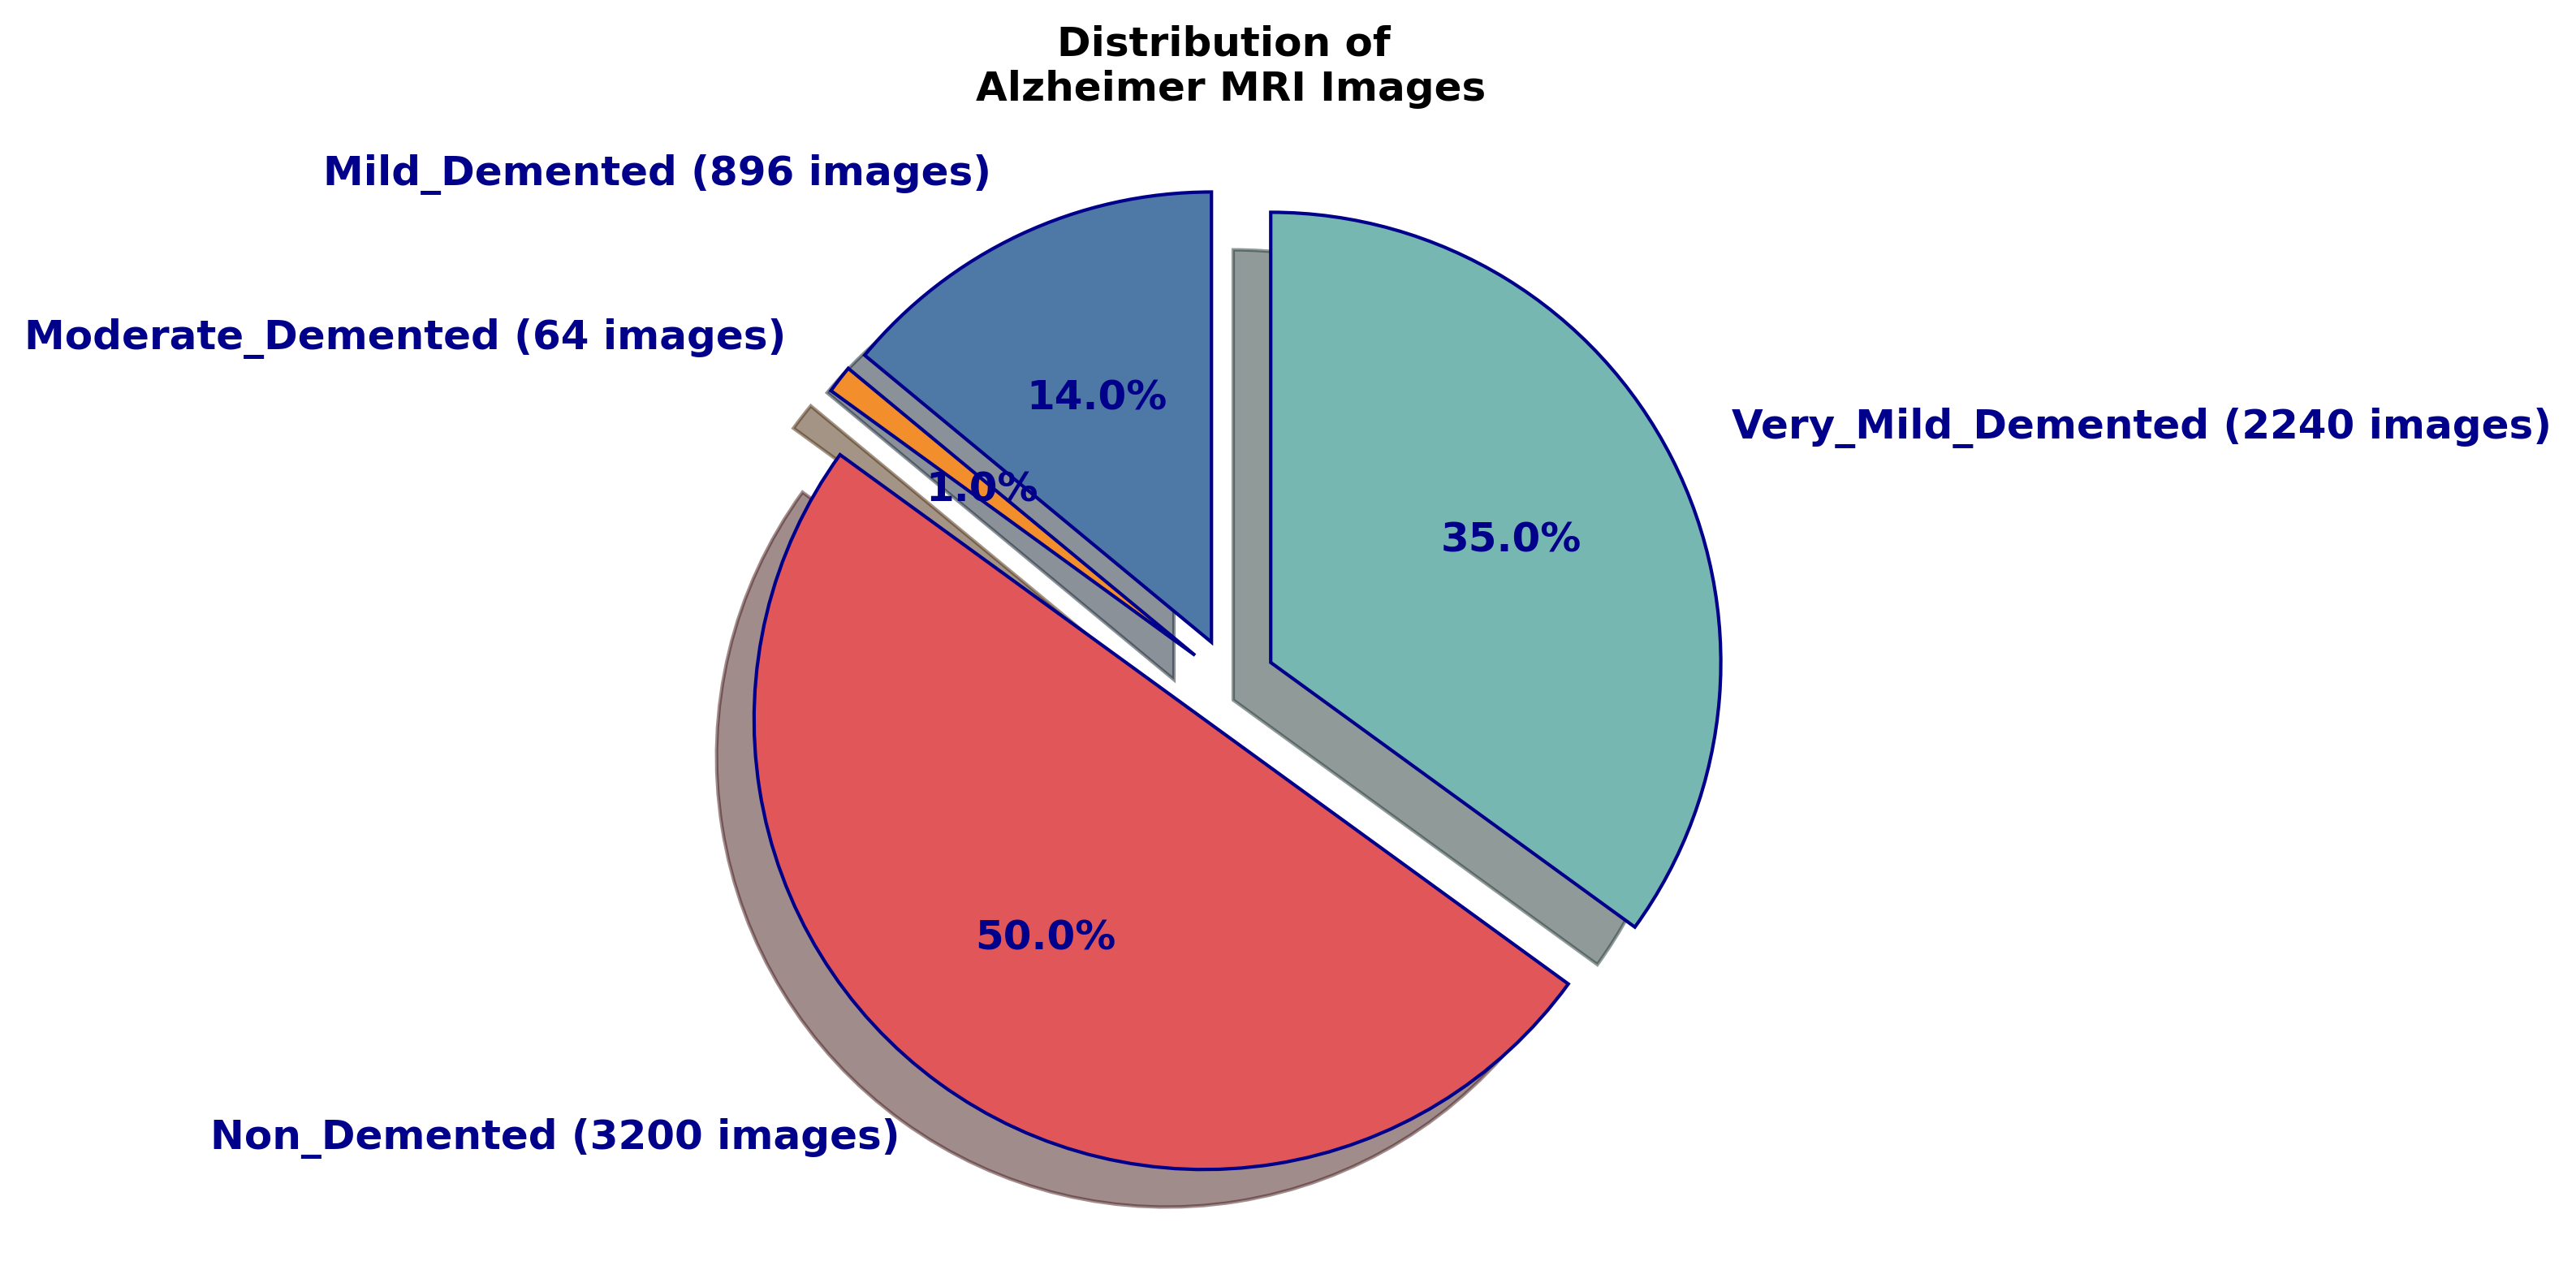

In [19]:
colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2"]

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300

class_dist = {}

def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1
            
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')
    
    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)
    
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]
    
    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold")

PATH = 'Dataset'

image_counter(PATH)


In [20]:

def sample_bringer(path, target, num_samples=5):
    class_path = os.path.join(path, target)
    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{target} Brain MRI Samples', color="yellow",fontsize=16, fontweight='bold', y=0.75)
    
    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()
    
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 6400 files belonging to 4 classes.


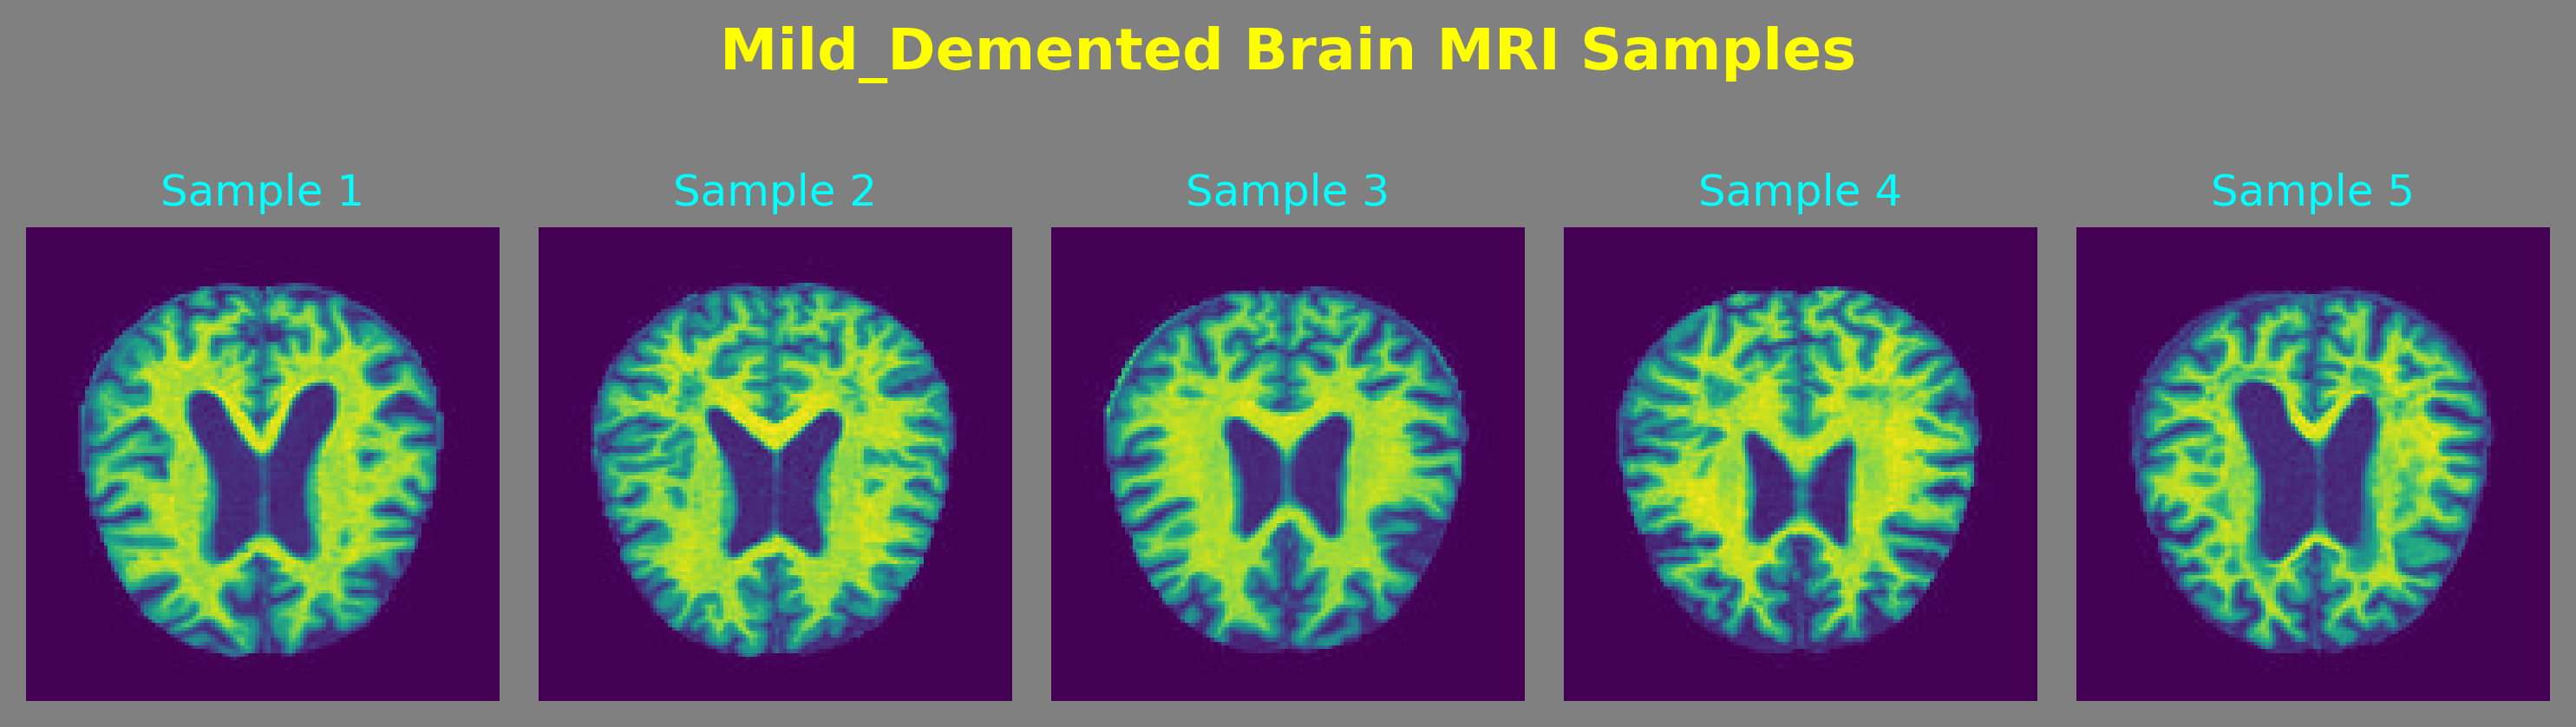

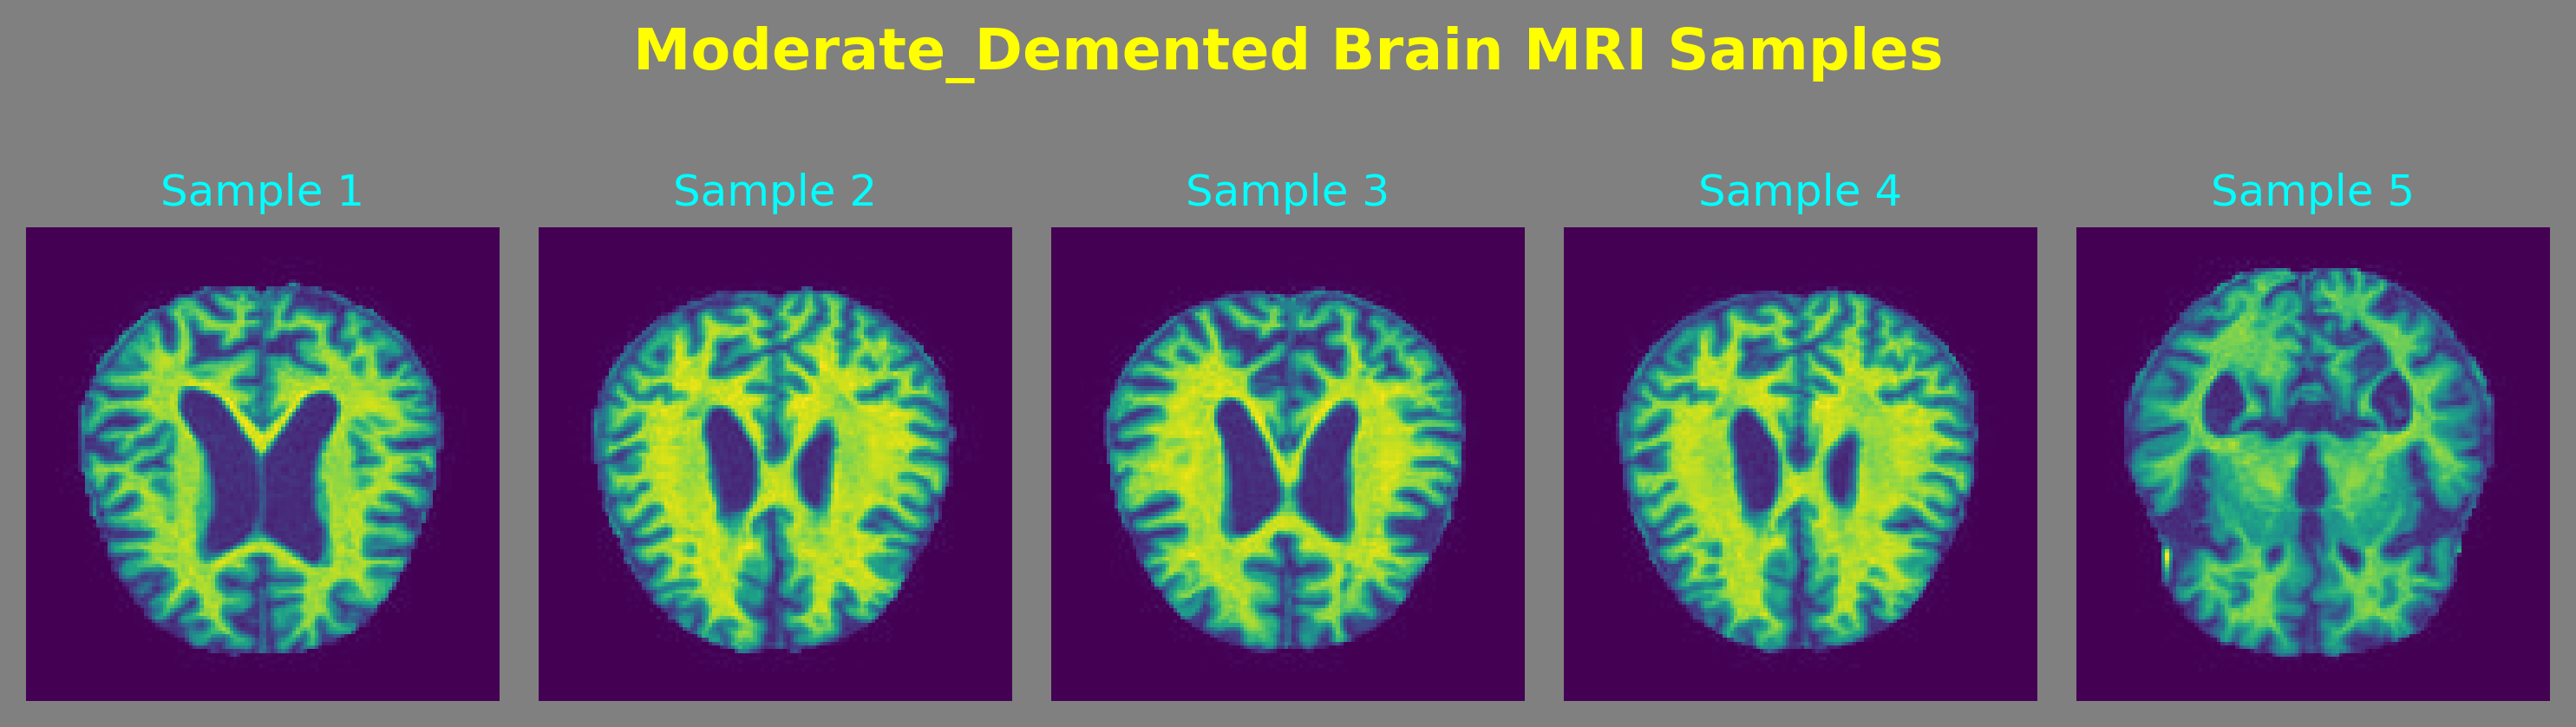

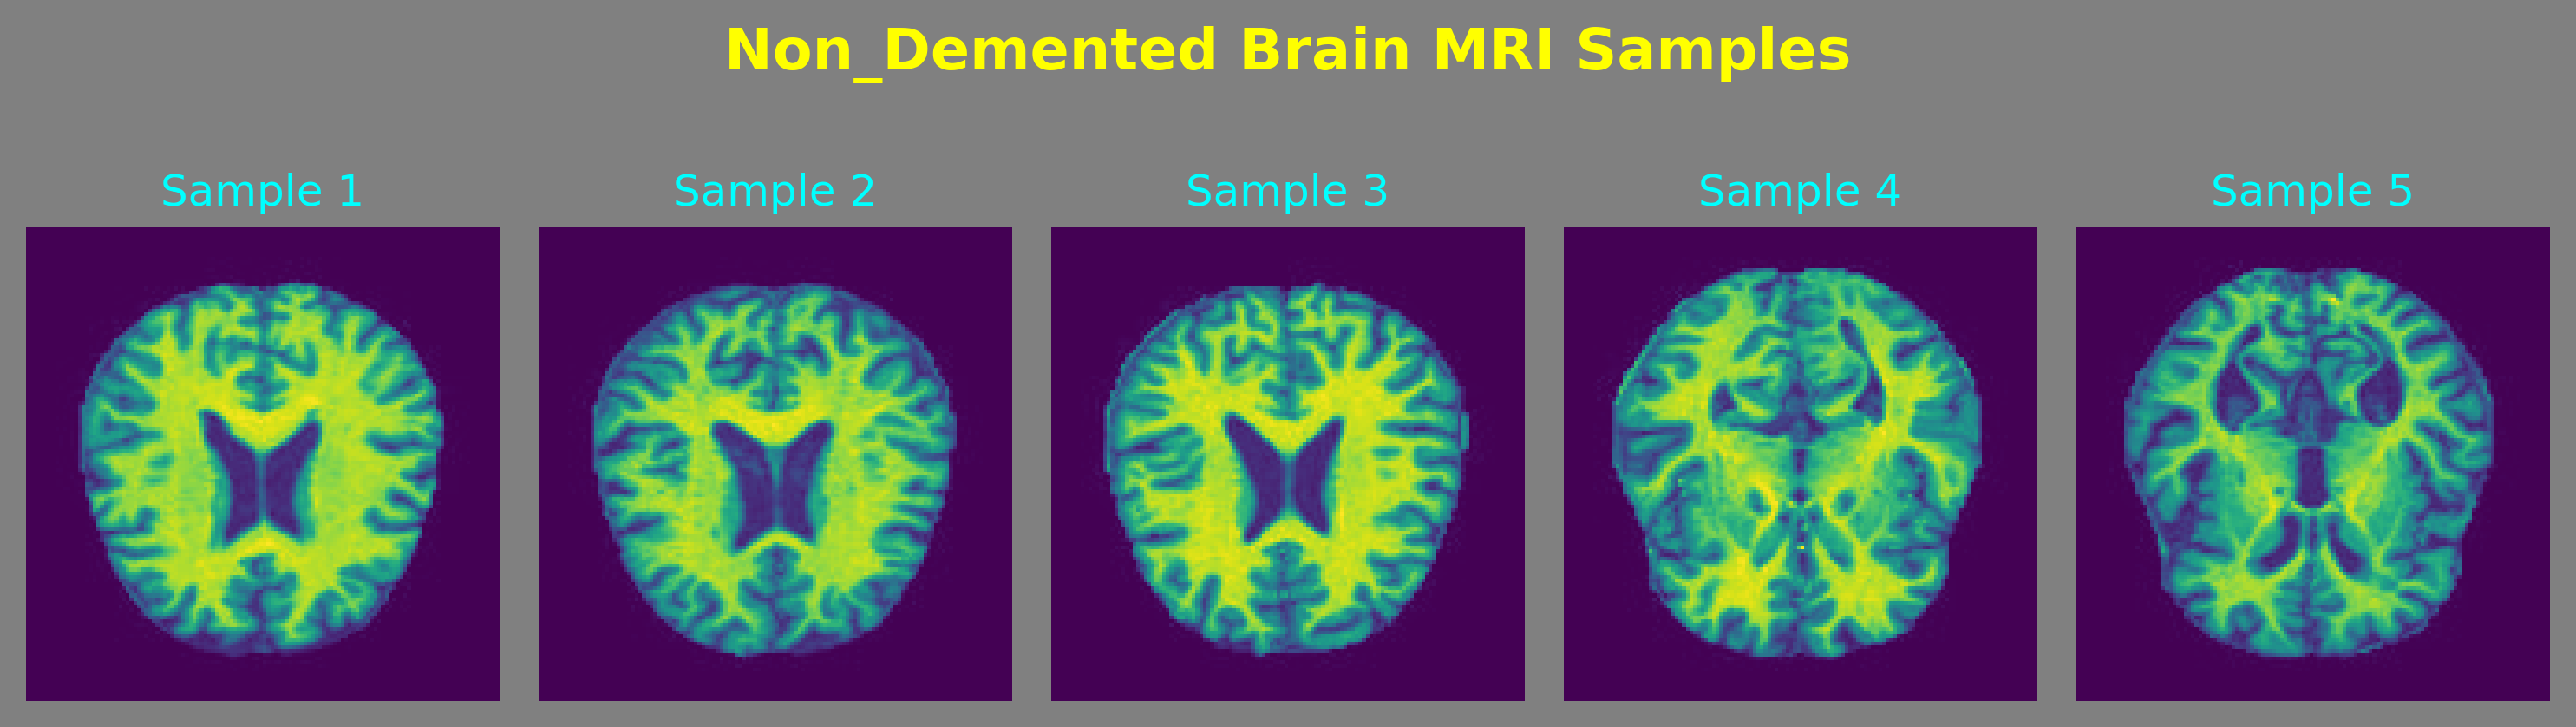

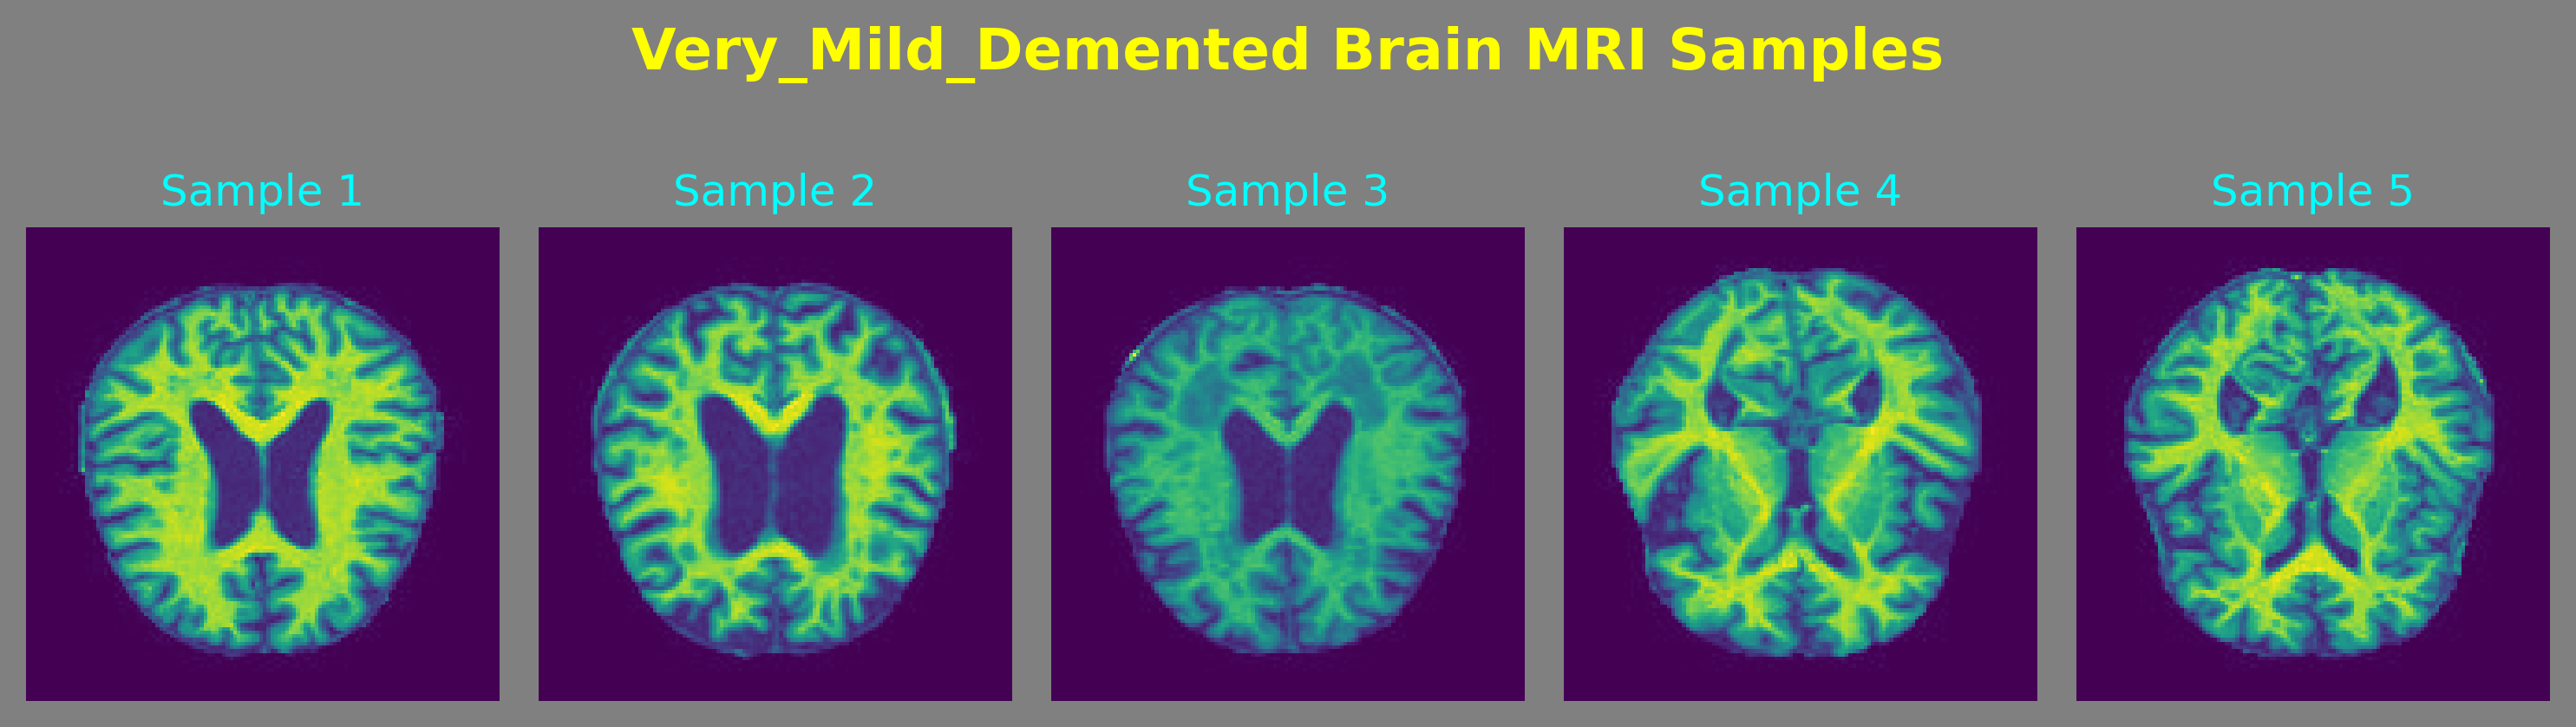

In [21]:
for target in class_names:
    sample_bringer(PATH, target=target)
    
alz_dict = {index: img for index, img in enumerate(data.class_names)}

Min and max pixel values in the batch -> 0.0 & 1.0


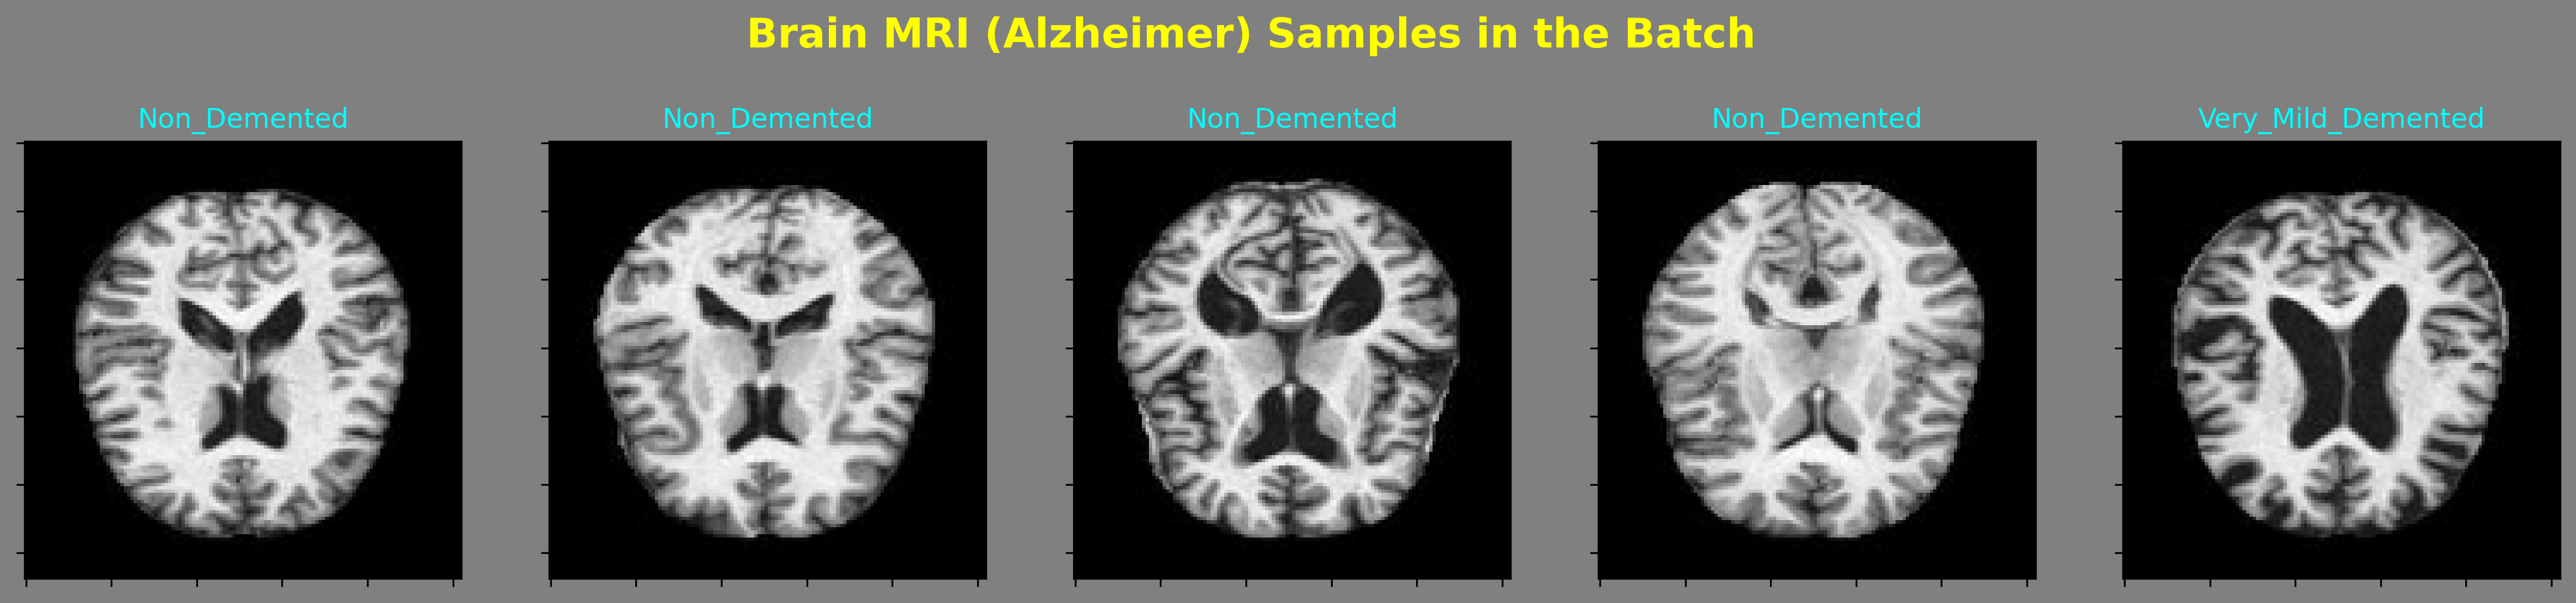

In [22]:
class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())
        
    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])
    
    def train_test_val_split(self, train_size, val_size, test_size):
        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)
        
        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)


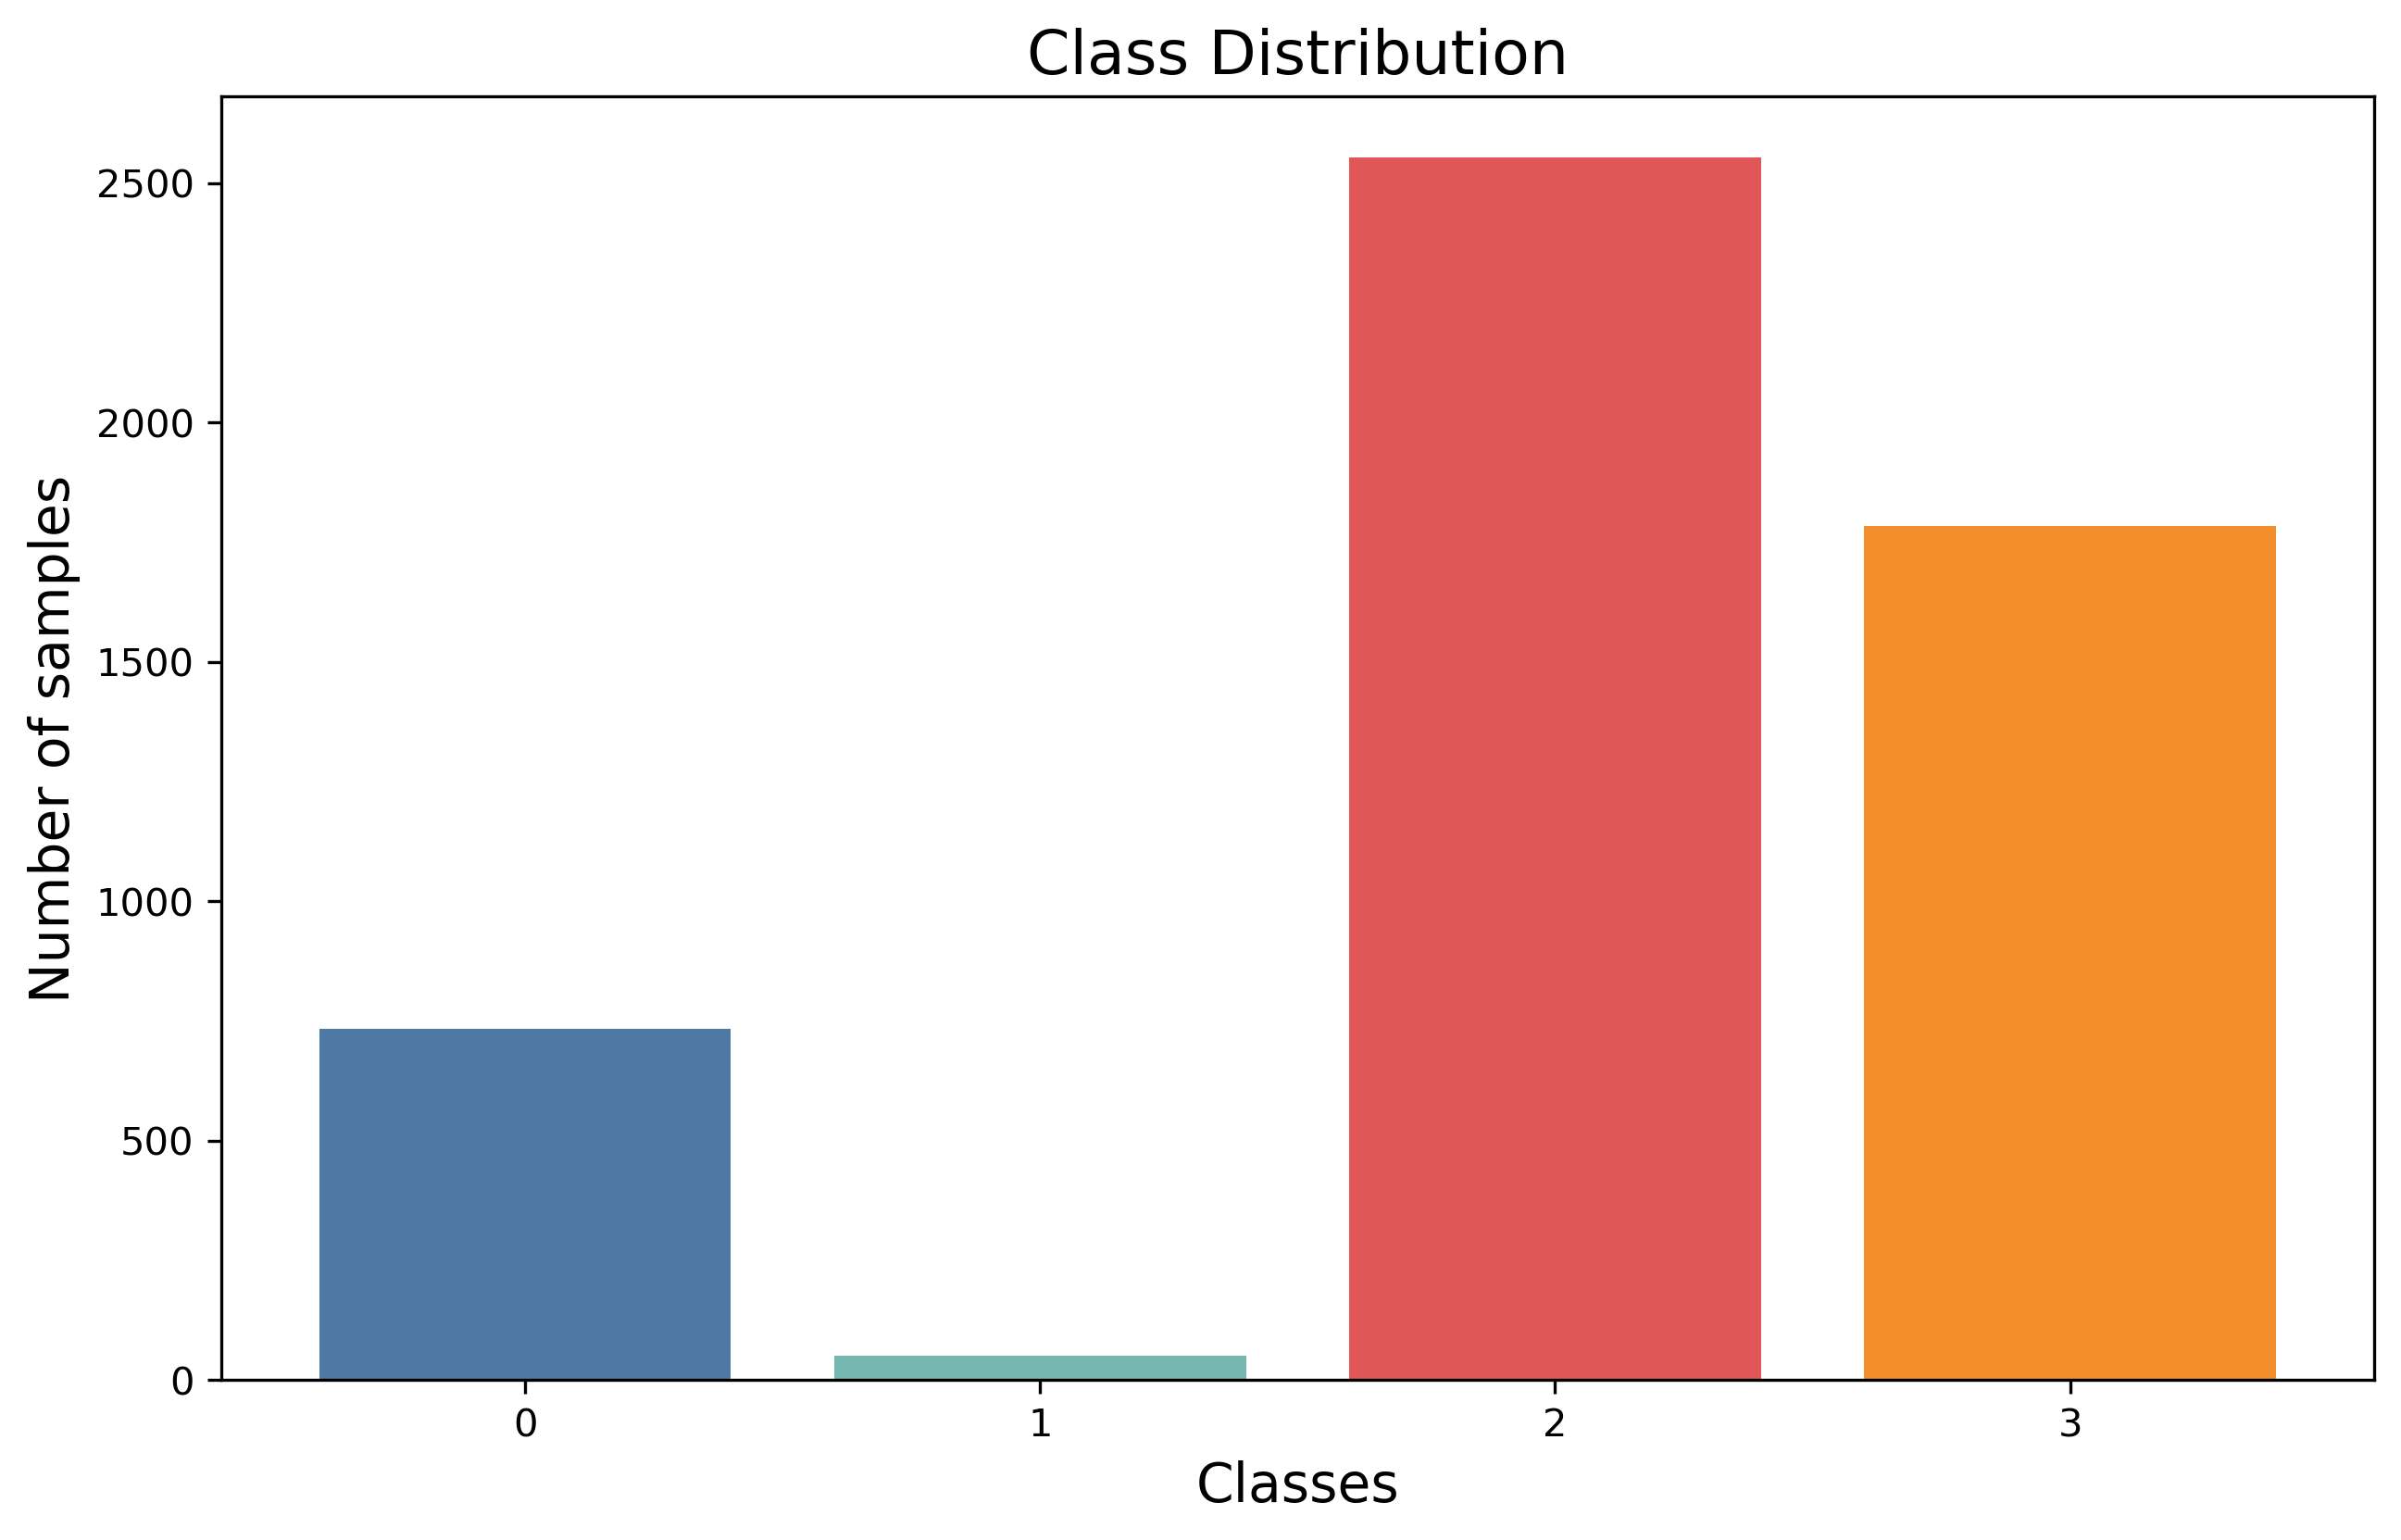

Class counts: {0: 734, 3: 1783, 2: 2553, 1: 50}


In [23]:
def check_data_imbalance(data):
    class_counts = {}
    
    for _, labels in data:
        labels = labels.numpy()
        for label in labels:
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color=colors)
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Number of samples', fontsize=14)
    plt.title('Class Distribution', fontsize=16)
    plt.xticks(classes)
    plt.show()

    return class_counts

class_counts = check_data_imbalance(train_data)
print("Class counts:", class_counts)


In [24]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

In [25]:
def checkpoint_callback():
    checkpoint_filepath = '/tmp/checkpoint.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        save_freq='epoch',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    return model_checkpoint_callback

def early_stopping(patience=5):
    es_callback = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=1
    )
    return es_callback

In [32]:
def build_cnn_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer='he_normal',
                     kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer='he_normal',
                     kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer='he_normal',
                     kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    model.summary()
    
    return model

In [33]:
def build_resnet_model():
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [34]:
def build_vgg_model():
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [35]:
def build_efficientnet_model():
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [36]:
def train_and_evaluate_model(model, train_data, val_data, class_weights, epochs=25):
    model_checkpoint = checkpoint_callback()
    early_stop = early_stopping()

    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        class_weight=class_weights,
        callbacks=[model_checkpoint, early_stop]
    )
    
    return history

In [37]:
cnn_model = build_cnn_model()
history = train_and_evaluate_model(cnn_model, train_data, val_data, class_weights, 50)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,549,444 (24.98 MB)

 Trainable params: 6,549,444 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.3045 - loss: 4.1992
Epoch 1: val_accuracy improved from -inf to 0.01719, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 68s 407ms/step - accuracy: 0.3044 - loss: 4.1907 - val_accuracy: 0.0172 - val_loss: 2.2313
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.2682 - loss: 2.0949
Epoch 2: val_accuracy did not improve from 0.01719
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 400ms/step - accuracy: 0.2683 - loss: 2.0952 - val_accuracy: 0.0156 - val_loss: 2.0693
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.1960 - loss: 1.9685
Epoch 3: val_accuracy did not improve from 0.01719
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 403ms/step - accuracy: 0.1961 - loss: 1.9689 - val_accuracy: 0.0141 - val_loss: 1.9795
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.1380 - loss: 1.9117
Epoch 4: val_accuracy did not improve from 0.01719
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 401ms/step 

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8002 - loss: 0.6137
Epoch 47: val_accuracy did not improve from 0.90781
160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 484ms/step - accuracy: 0.8002 - loss: 0.6139 - val_accuracy: 0.8828 - val_loss: 0.6281
Epoch 48/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7597 - loss: 0.7082
Epoch 48: val_accuracy improved from 0.90781 to 0.91875, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 79s 492ms/step - accuracy: 0.7597 - loss: 0.7082 - val_accuracy: 0.9187 - val_loss: 0.5568
Epoch 48: early stopping


In [47]:
def random_mri_prob_bringer( model, image_number=0):
    
    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = model.predict(tf.expand_dims(image, 0))[0]
        
    probs = list(tf.nn.softmax(pred).numpy()) 
    probs_dict = dict(zip(class_dist.keys(), probs))
    
    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4) 
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)
    
    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])        
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('Alzheimer Probabilities', color="yellow", fontweight="bold", fontsize=16)

predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = cnn_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.90      0.94        91
 Moderate_Demented       0.86      1.00      0.92         6
      Non_Demented       0.91      0.93      0.92       322
Very_Mild_Demented       0.86      0.87      0.87       221

          accuracy                           0.91       640
         macro avg       0.91      0.93      0.91       640
      weighted avg       0.91      0.91      0.91       640



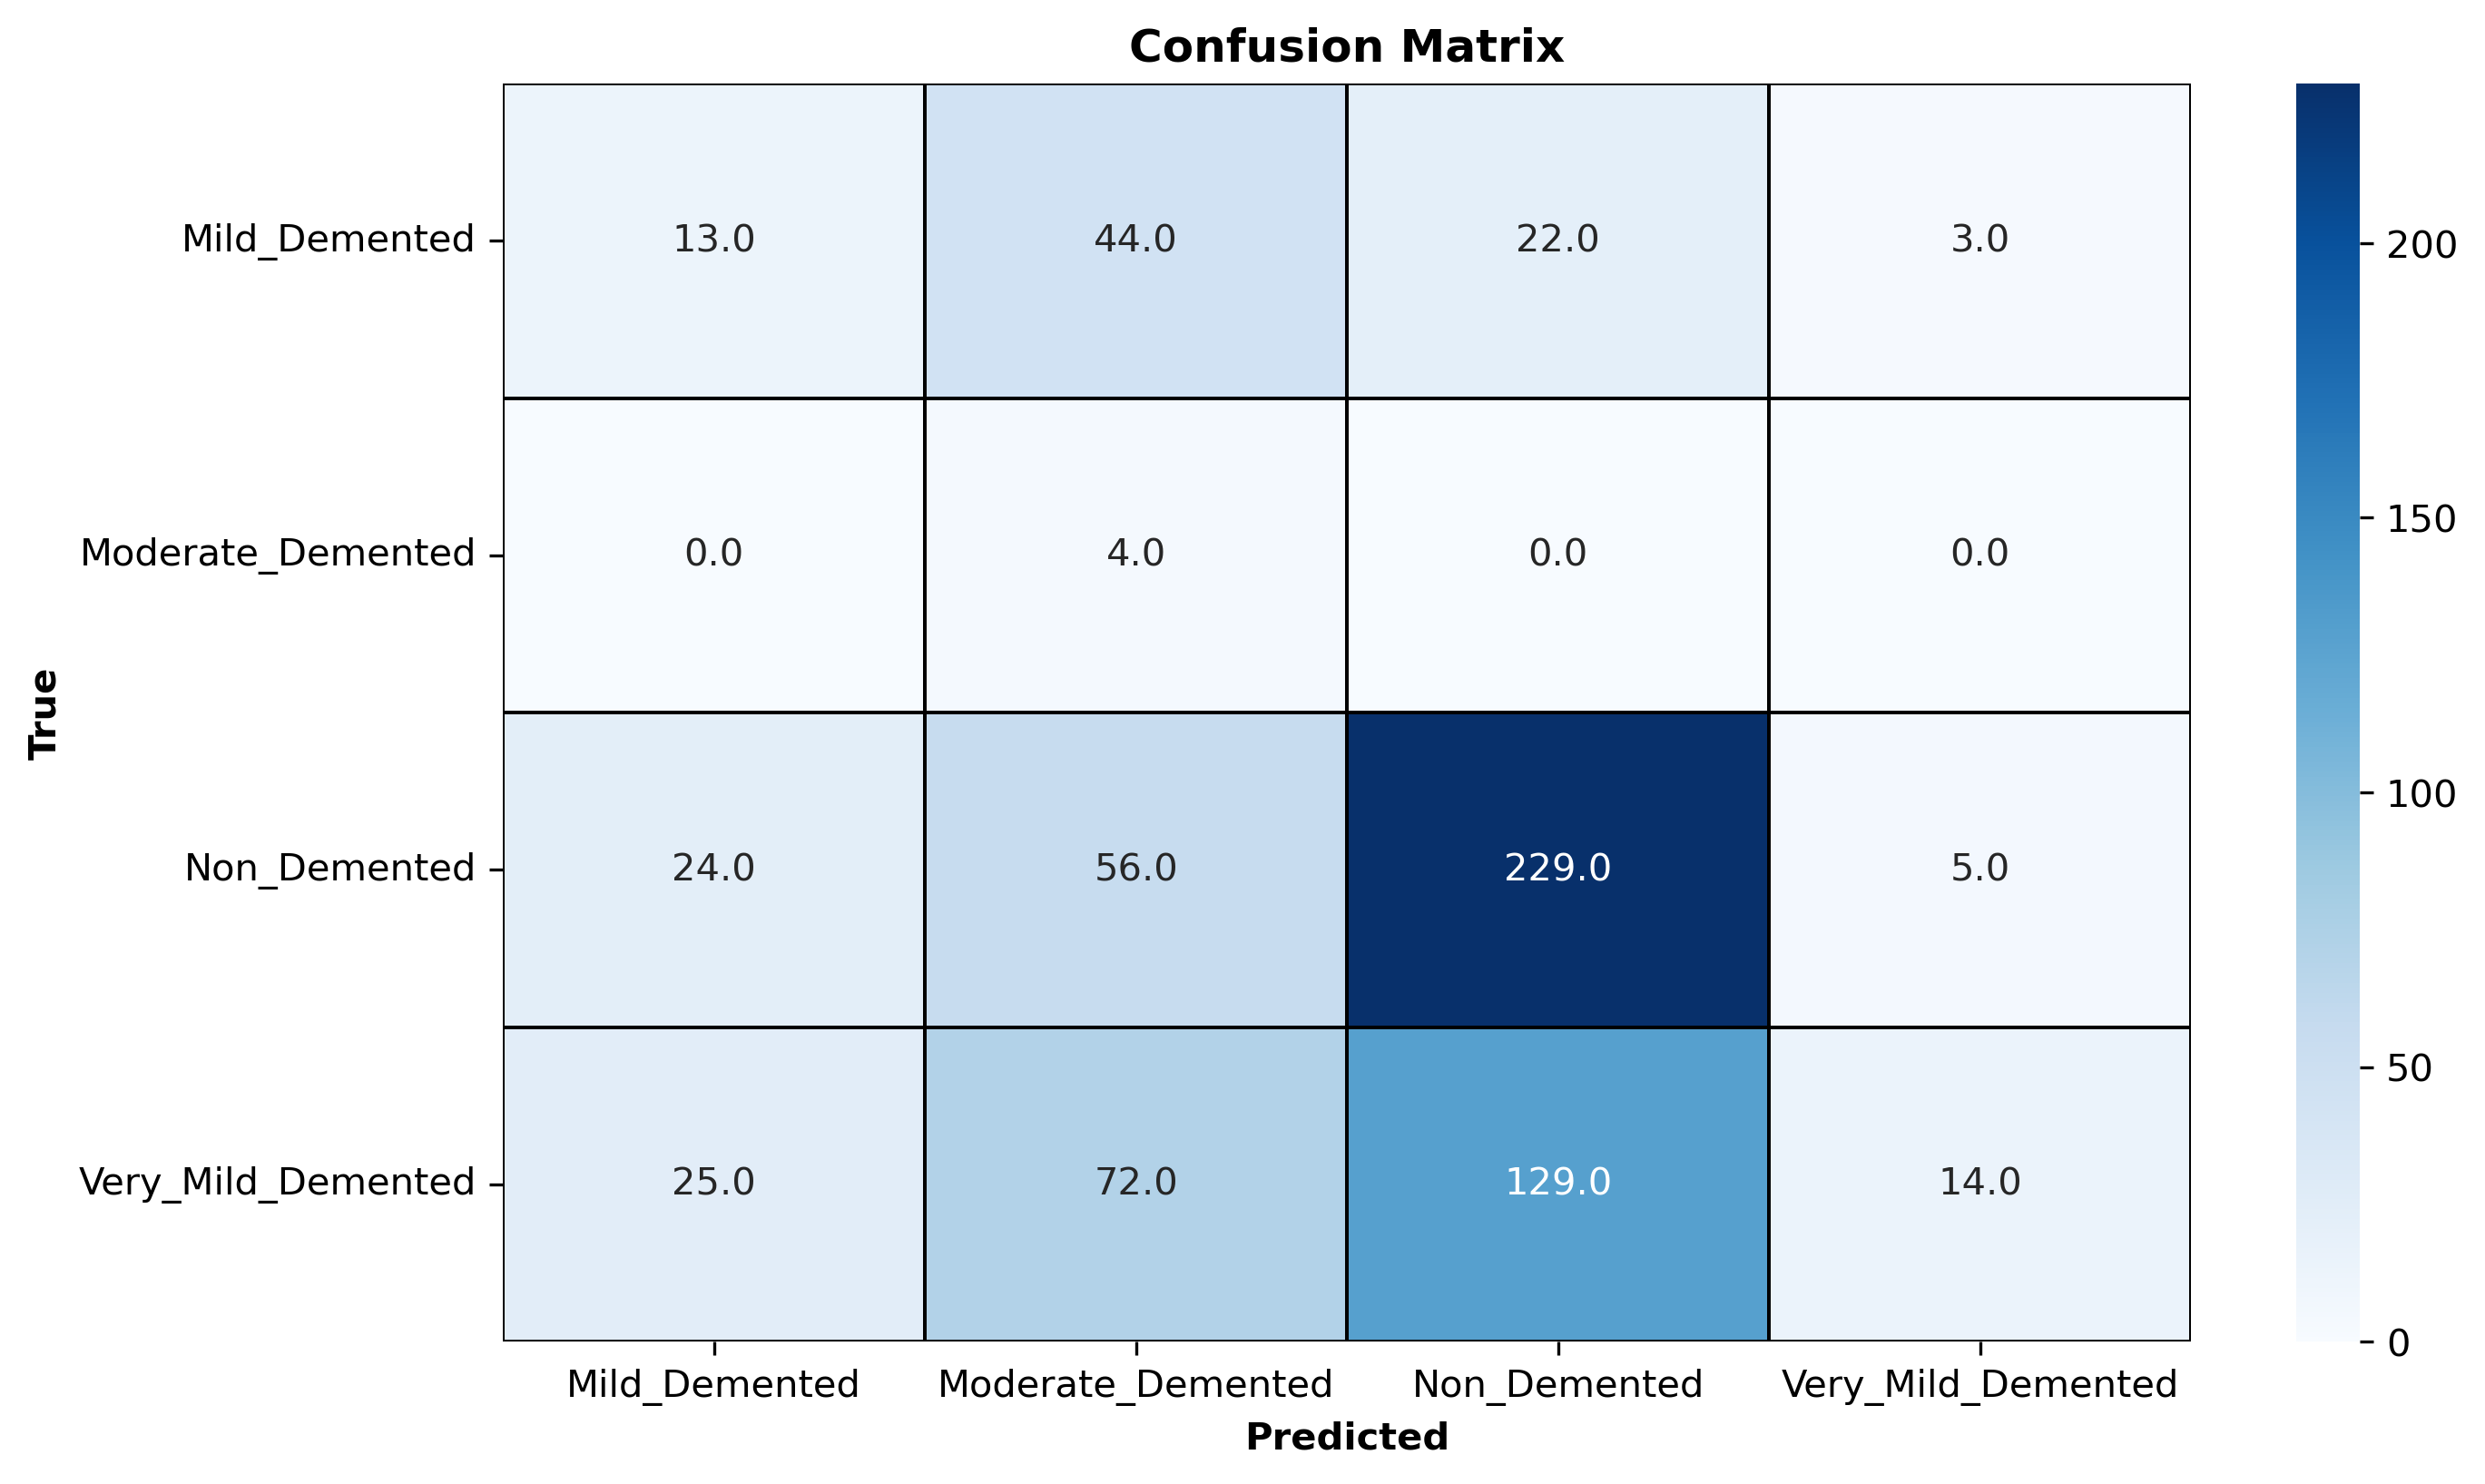

In [52]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f", linewidths=0.5, linecolor='black')

plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


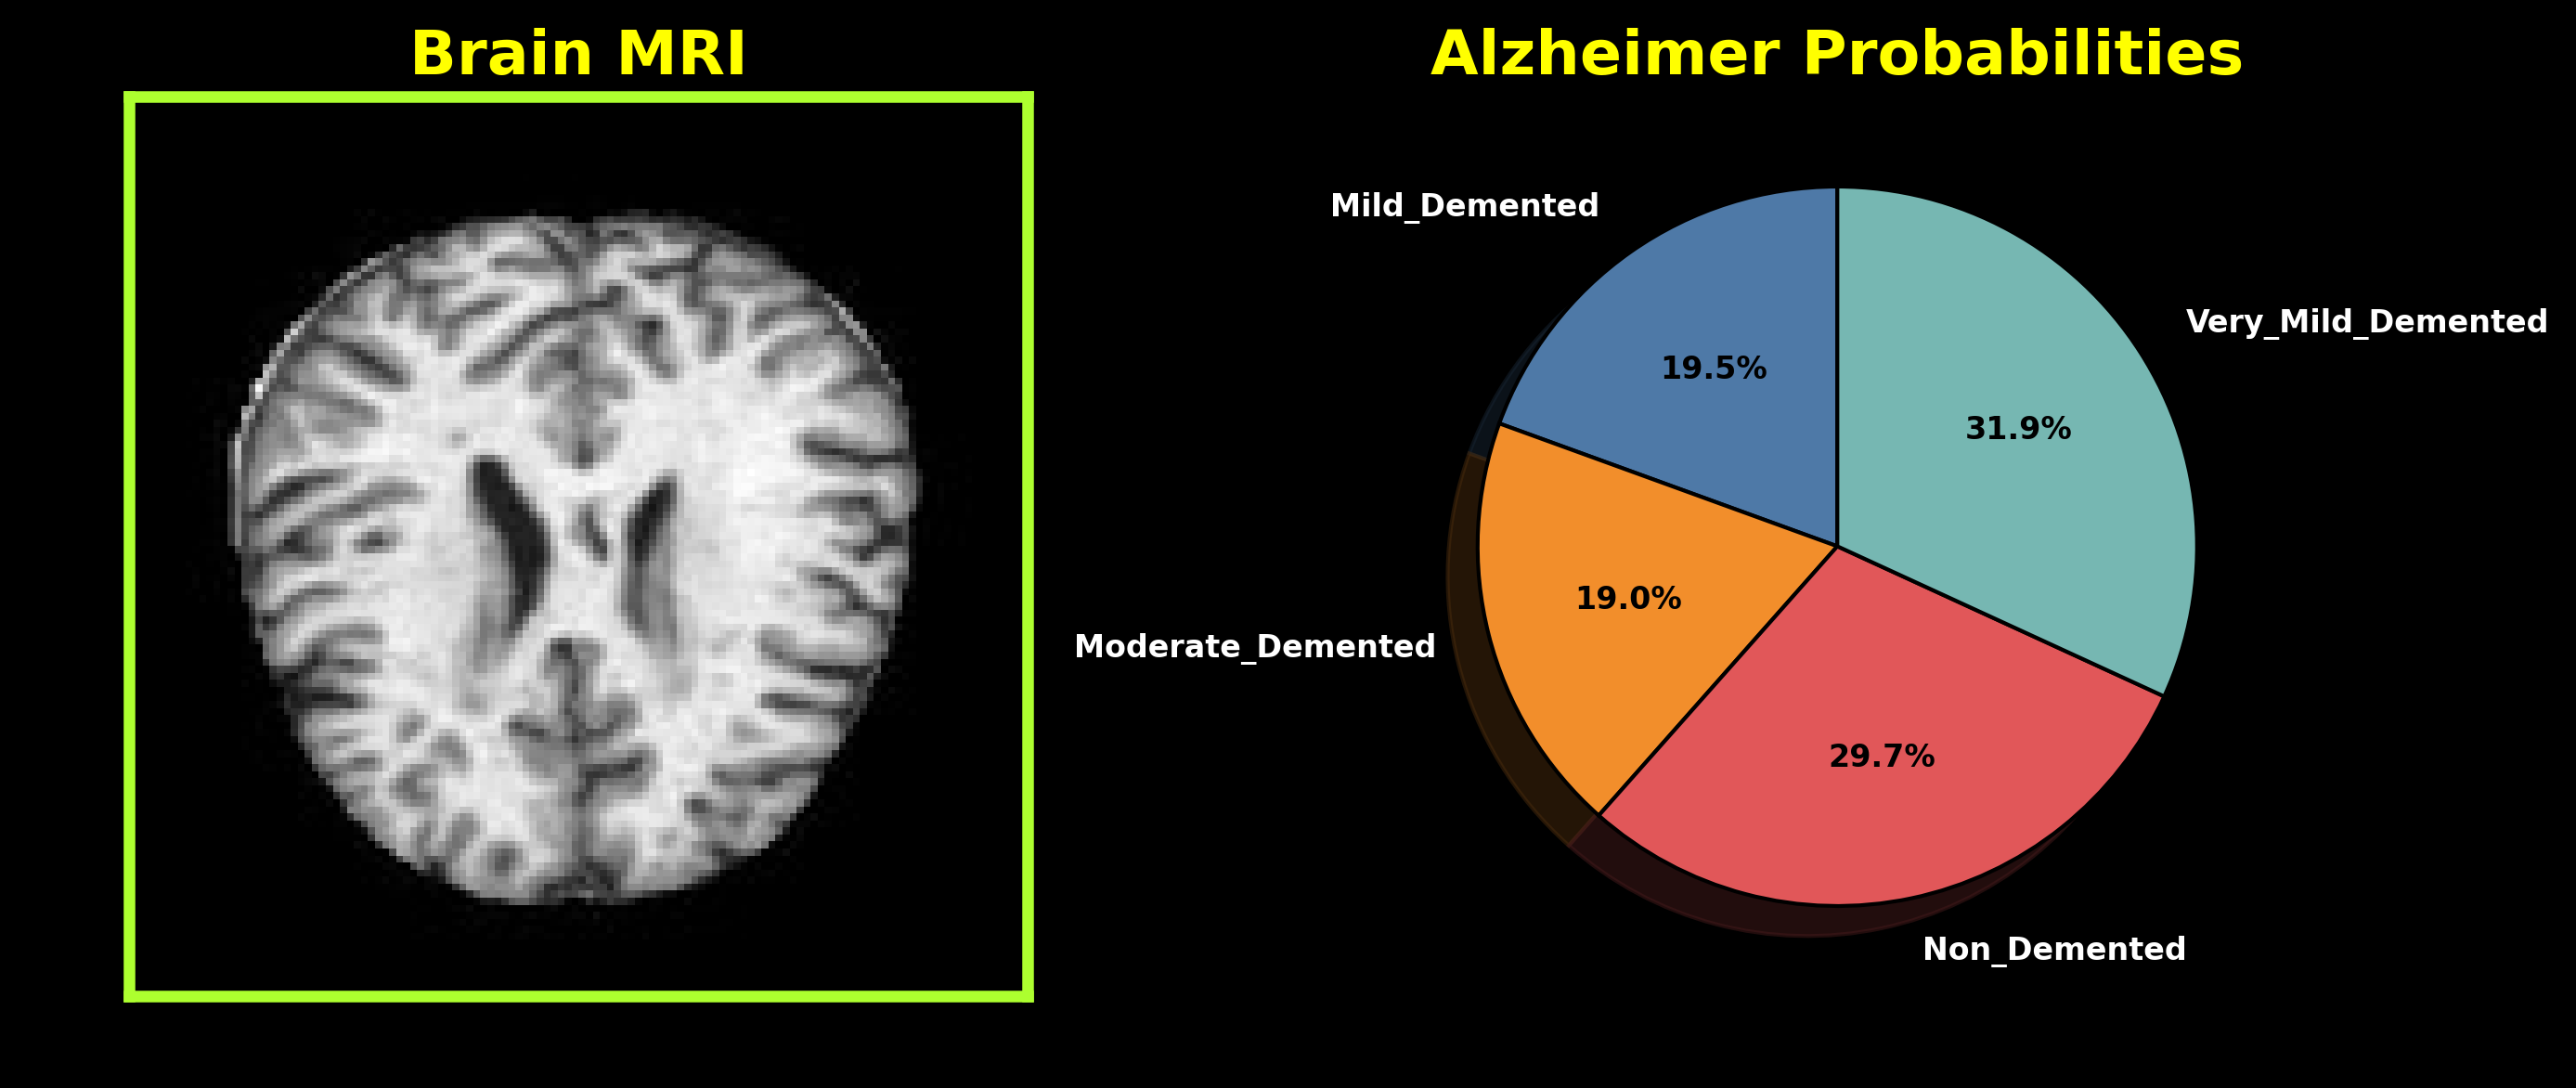

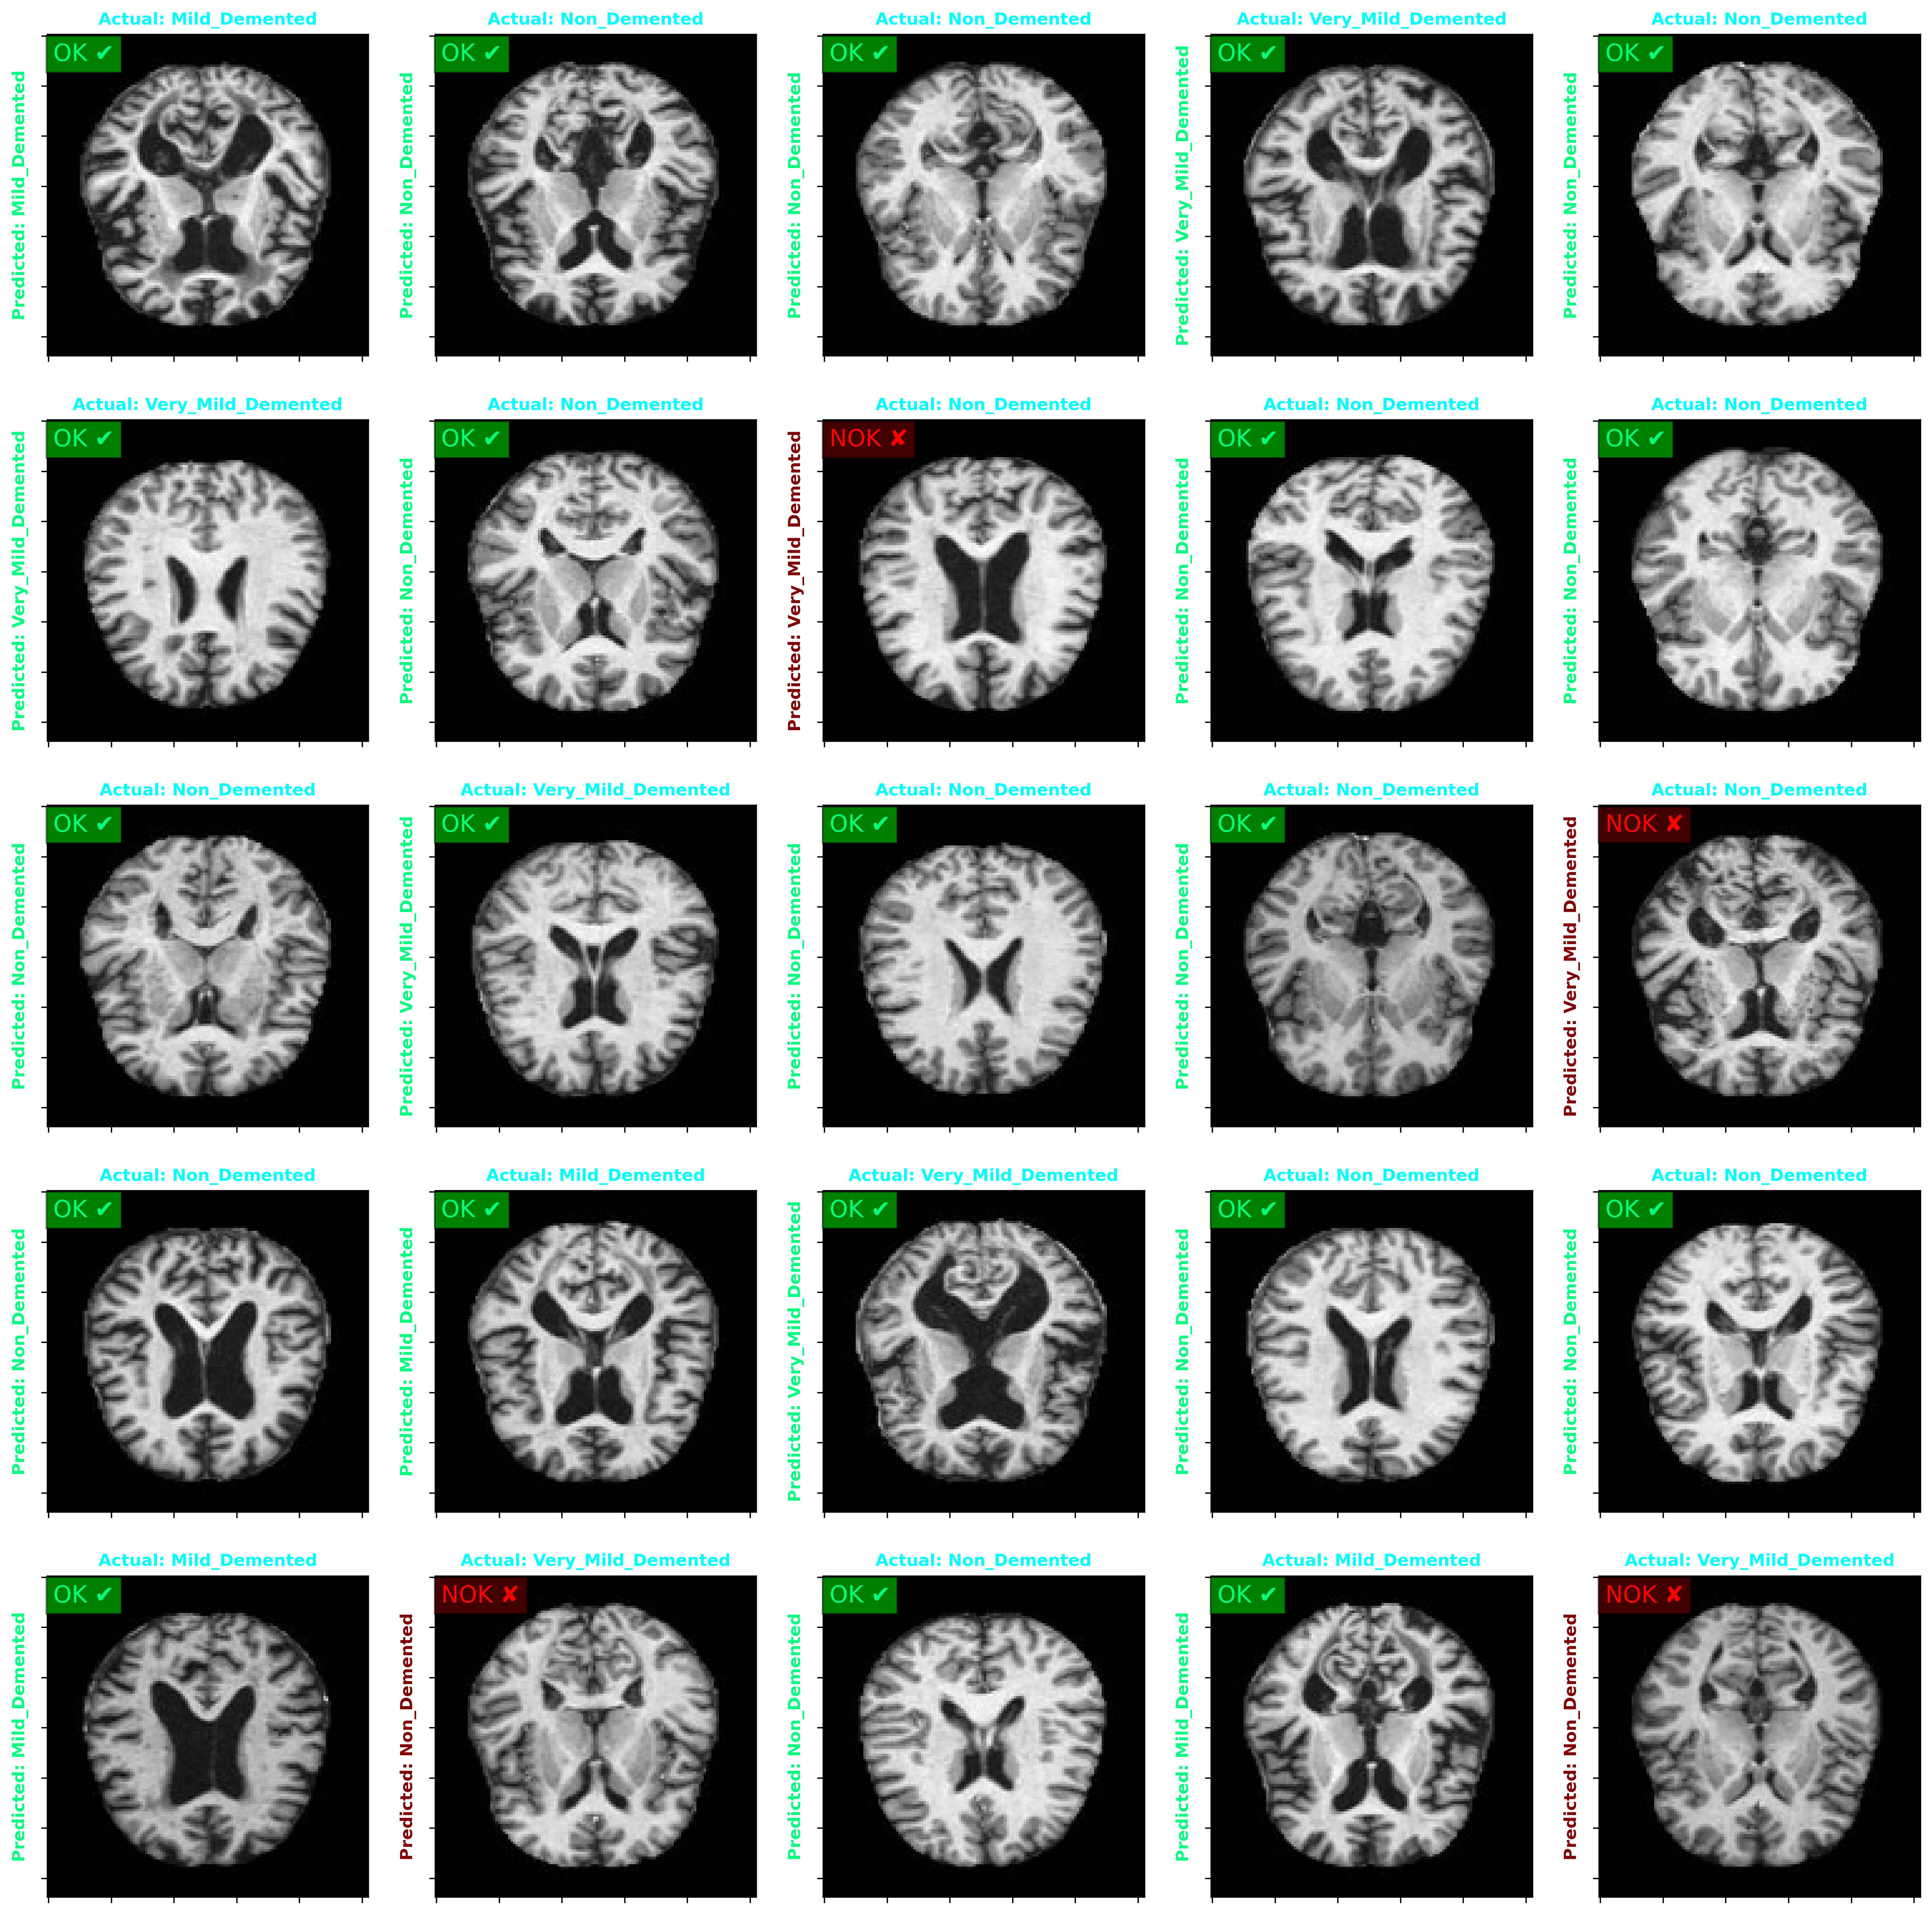

In [49]:
rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(cnn_model, image_number=rand_img_no)

plt.figure(figsize=(20, 20), facecolor="white")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = cnn_model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
    
        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

In [50]:
resnet_model = build_resnet_model()
history = train_and_evaluate_model(resnet_model, train_data, val_data, class_weights, 50)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.2608 - loss: 1.3468
Epoch 1: val_accuracy improved from -inf to 0.01406, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 152s 902ms/step - accuracy: 0.2608 - loss: 1.3472 - val_accuracy: 0.0141 - val_loss: 1.9824
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.3163 - loss: 1.3497
Epoch 2: val_accuracy improved from 0.01406 to 0.14844, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 144s 898ms/step - accuracy: 0.3164 - loss: 1.3499 - val_accuracy: 0.1484 - val_loss: 1.4739
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.3454 - loss: 1.2709
Epoch 3: val_accuracy did not improve from 0.14844
160/160 ━━━━━━━━━━━━━━━━━━━━ 133s 830ms/step - accuracy: 0.3454 - loss: 1.2713 - val_accuracy: 0.1375 - val_loss: 1.5339
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.3551 - loss: 1.2631
Epoch 4: val_accuracy did not improve from 0.1484

In [51]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = resnet_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.21      0.16      0.18        82
 Moderate_Demented       0.02      1.00      0.04         4
      Non_Demented       0.60      0.73      0.66       314
Very_Mild_Demented       0.64      0.06      0.11       240

          accuracy                           0.41       640
         macro avg       0.37      0.49      0.25       640
      weighted avg       0.56      0.41      0.39       640



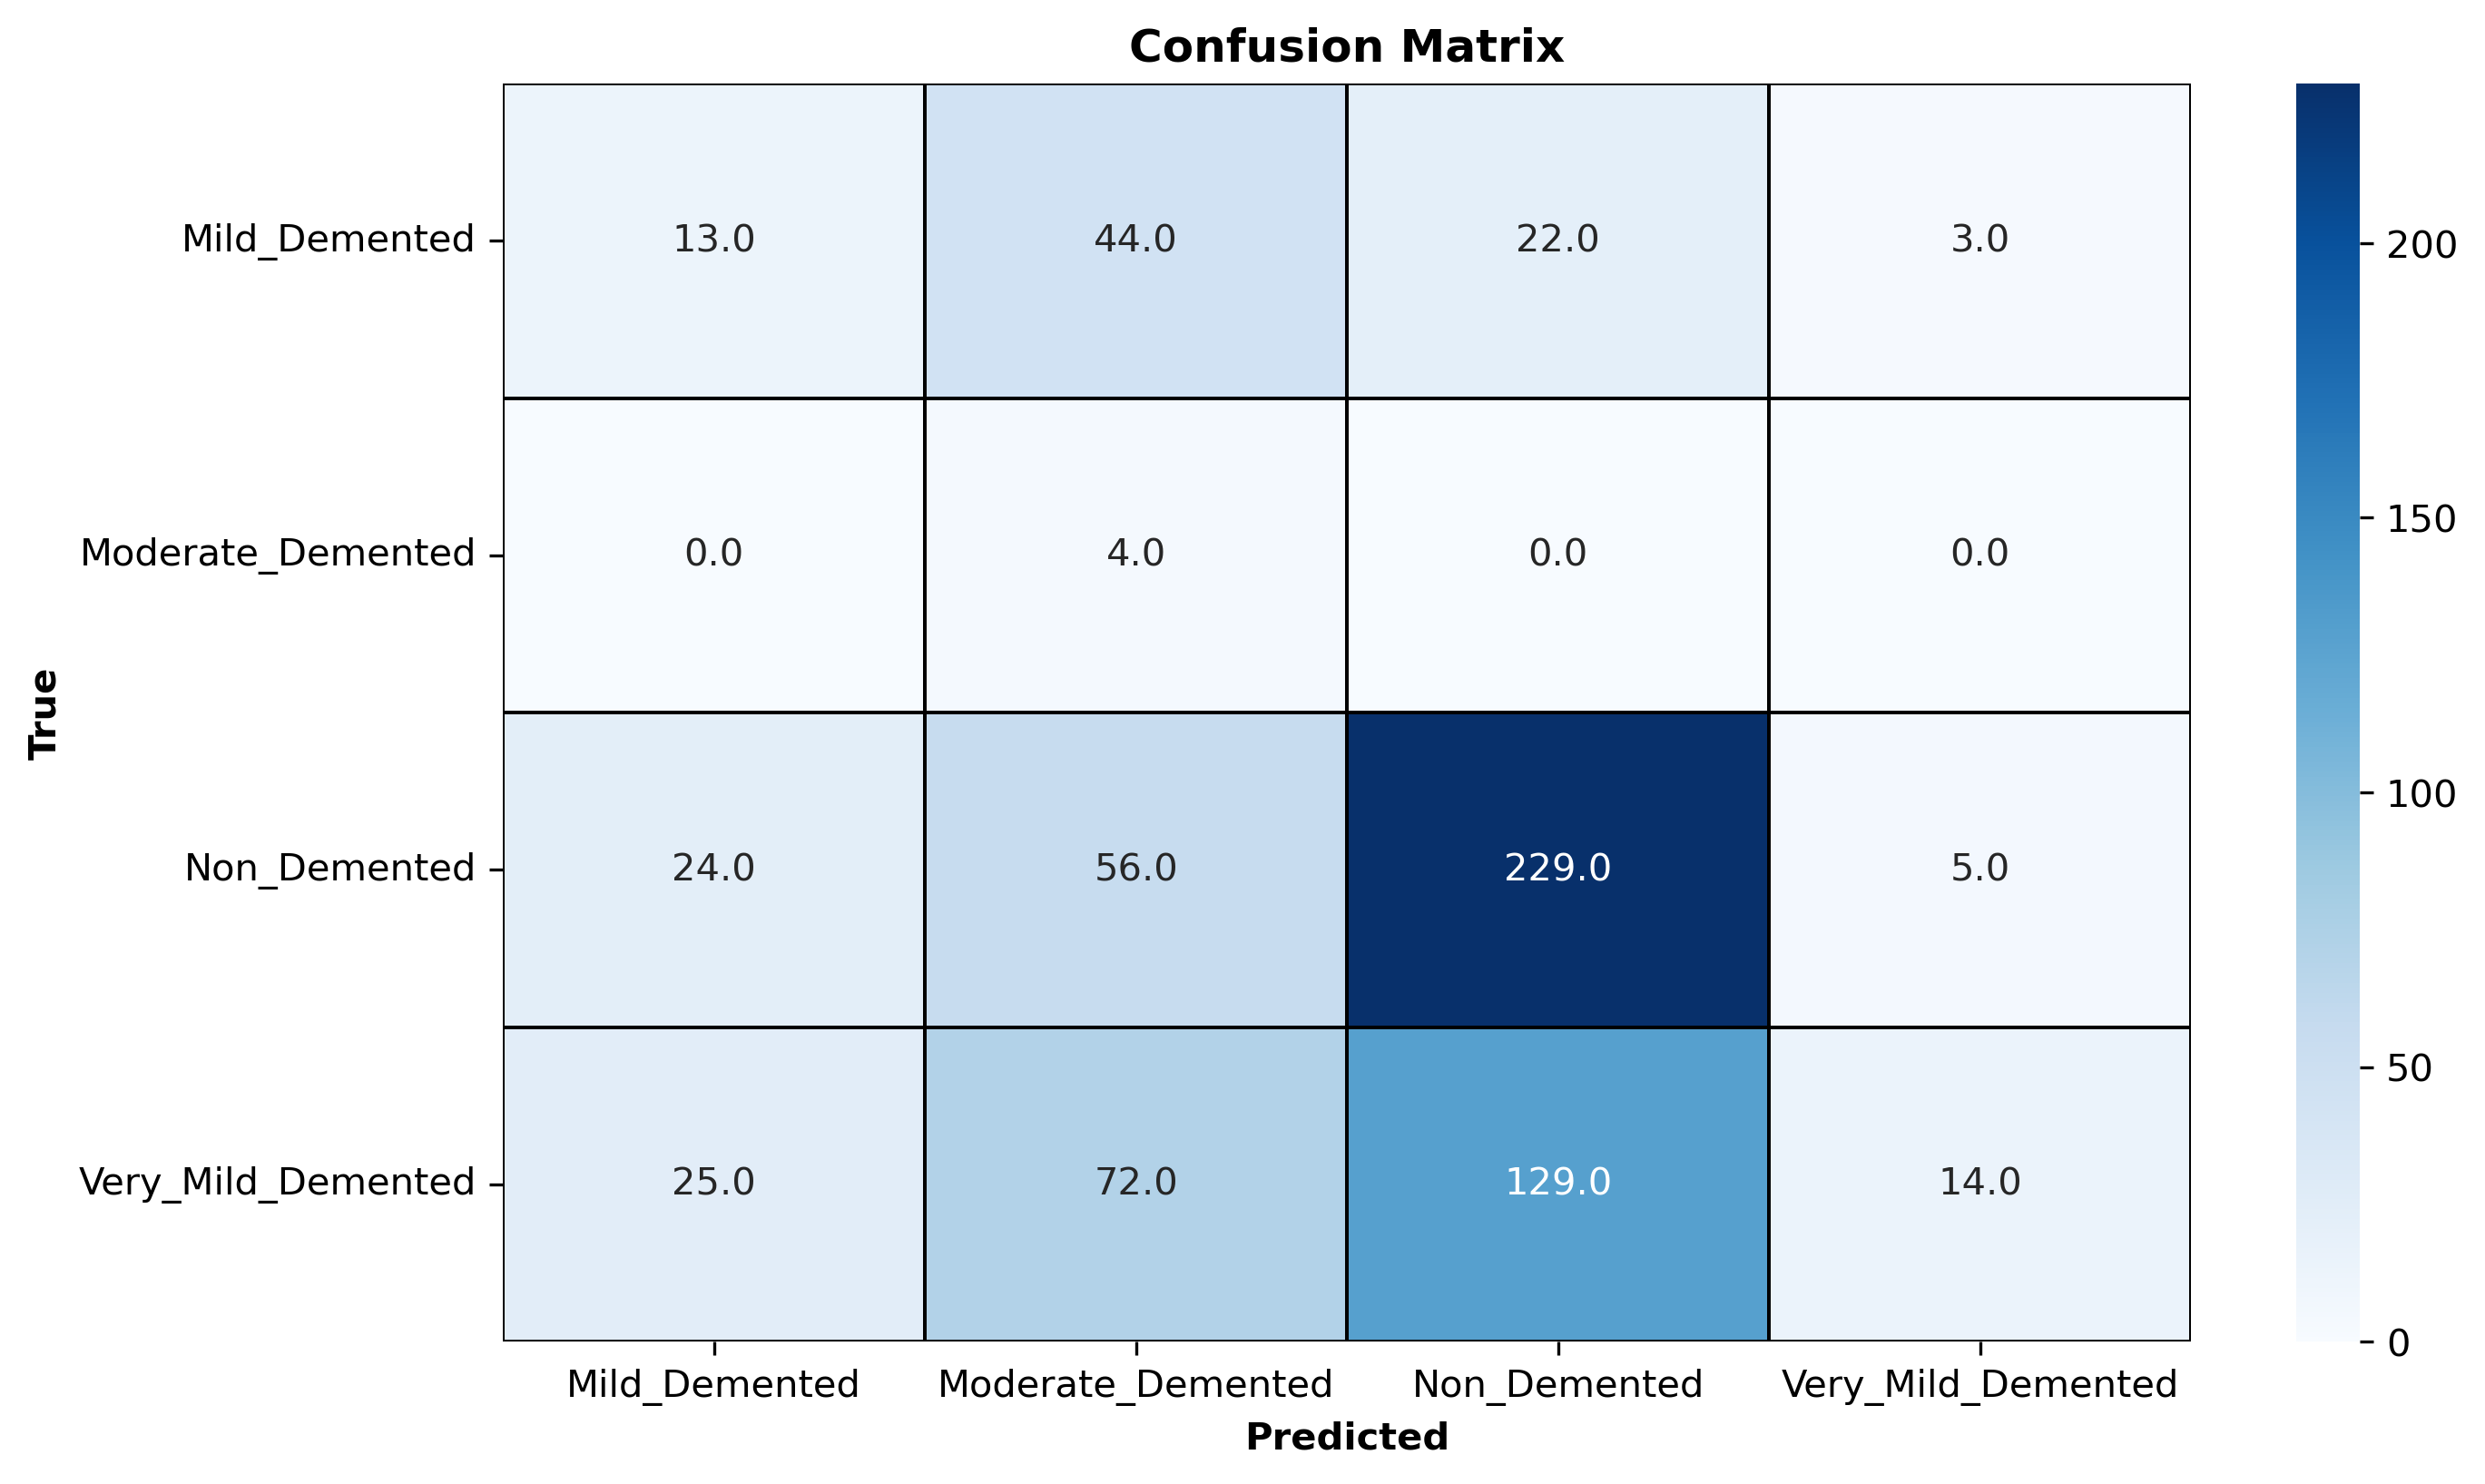

In [53]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f", linewidths=0.5, linecolor='black')

plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

plt.show()

In [54]:
vgg_model = build_vgg_model()
history = train_and_evaluate_model(vgg_model, train_data, val_data, class_weights, 50)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2859 - loss: 1.3141
Epoch 1: val_accuracy improved from -inf to 0.02344, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.2859 - loss: 1.3145 - val_accuracy: 0.0234 - val_loss: 1.7484
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3402 - loss: 1.2662
Epoch 2: val_accuracy improved from 0.02344 to 0.22344, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.3404 - loss: 1.2666 - val_accuracy: 0.2234 - val_loss: 1.5200
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4253 - loss: 1.1808
Epoch 3: val_accuracy improved from 0.22344 to 0.24688, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.4253 - loss: 1.1812 - val_accuracy: 0.2469 - val_loss: 1.4876
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4127 - loss: 1.1857
Epoch 4: val_accuracy impro

160/160 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.6101 - loss: 0.6492 - val_accuracy: 0.5875 - val_loss: 0.8917
Epoch 25/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6080 - loss: 0.7125
Epoch 25: val_accuracy did not improve from 0.62656
160/160 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.6080 - loss: 0.7125 - val_accuracy: 0.6187 - val_loss: 0.7808
Epoch 26/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6267 - loss: 0.6197
Epoch 26: val_accuracy did not improve from 0.62656
160/160 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.6267 - loss: 0.6197 - val_accuracy: 0.6187 - val_loss: 0.8269
Epoch 27/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6256 - loss: 0.6220
Epoch 27: val_accuracy improved from 0.62656 to 0.64062, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.6255 - loss: 0.6223 - val_accuracy: 0.6406 - val_loss: 0.7721
Epoch 28/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6290 

In [55]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = vgg_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.44      0.82      0.57        89
 Moderate_Demented       0.19      1.00      0.31         5
      Non_Demented       0.81      0.68      0.74       318
Very_Mild_Demented       0.66      0.51      0.58       228

          accuracy                           0.64       640
         macro avg       0.52      0.75      0.55       640
      weighted avg       0.70      0.64      0.65       640



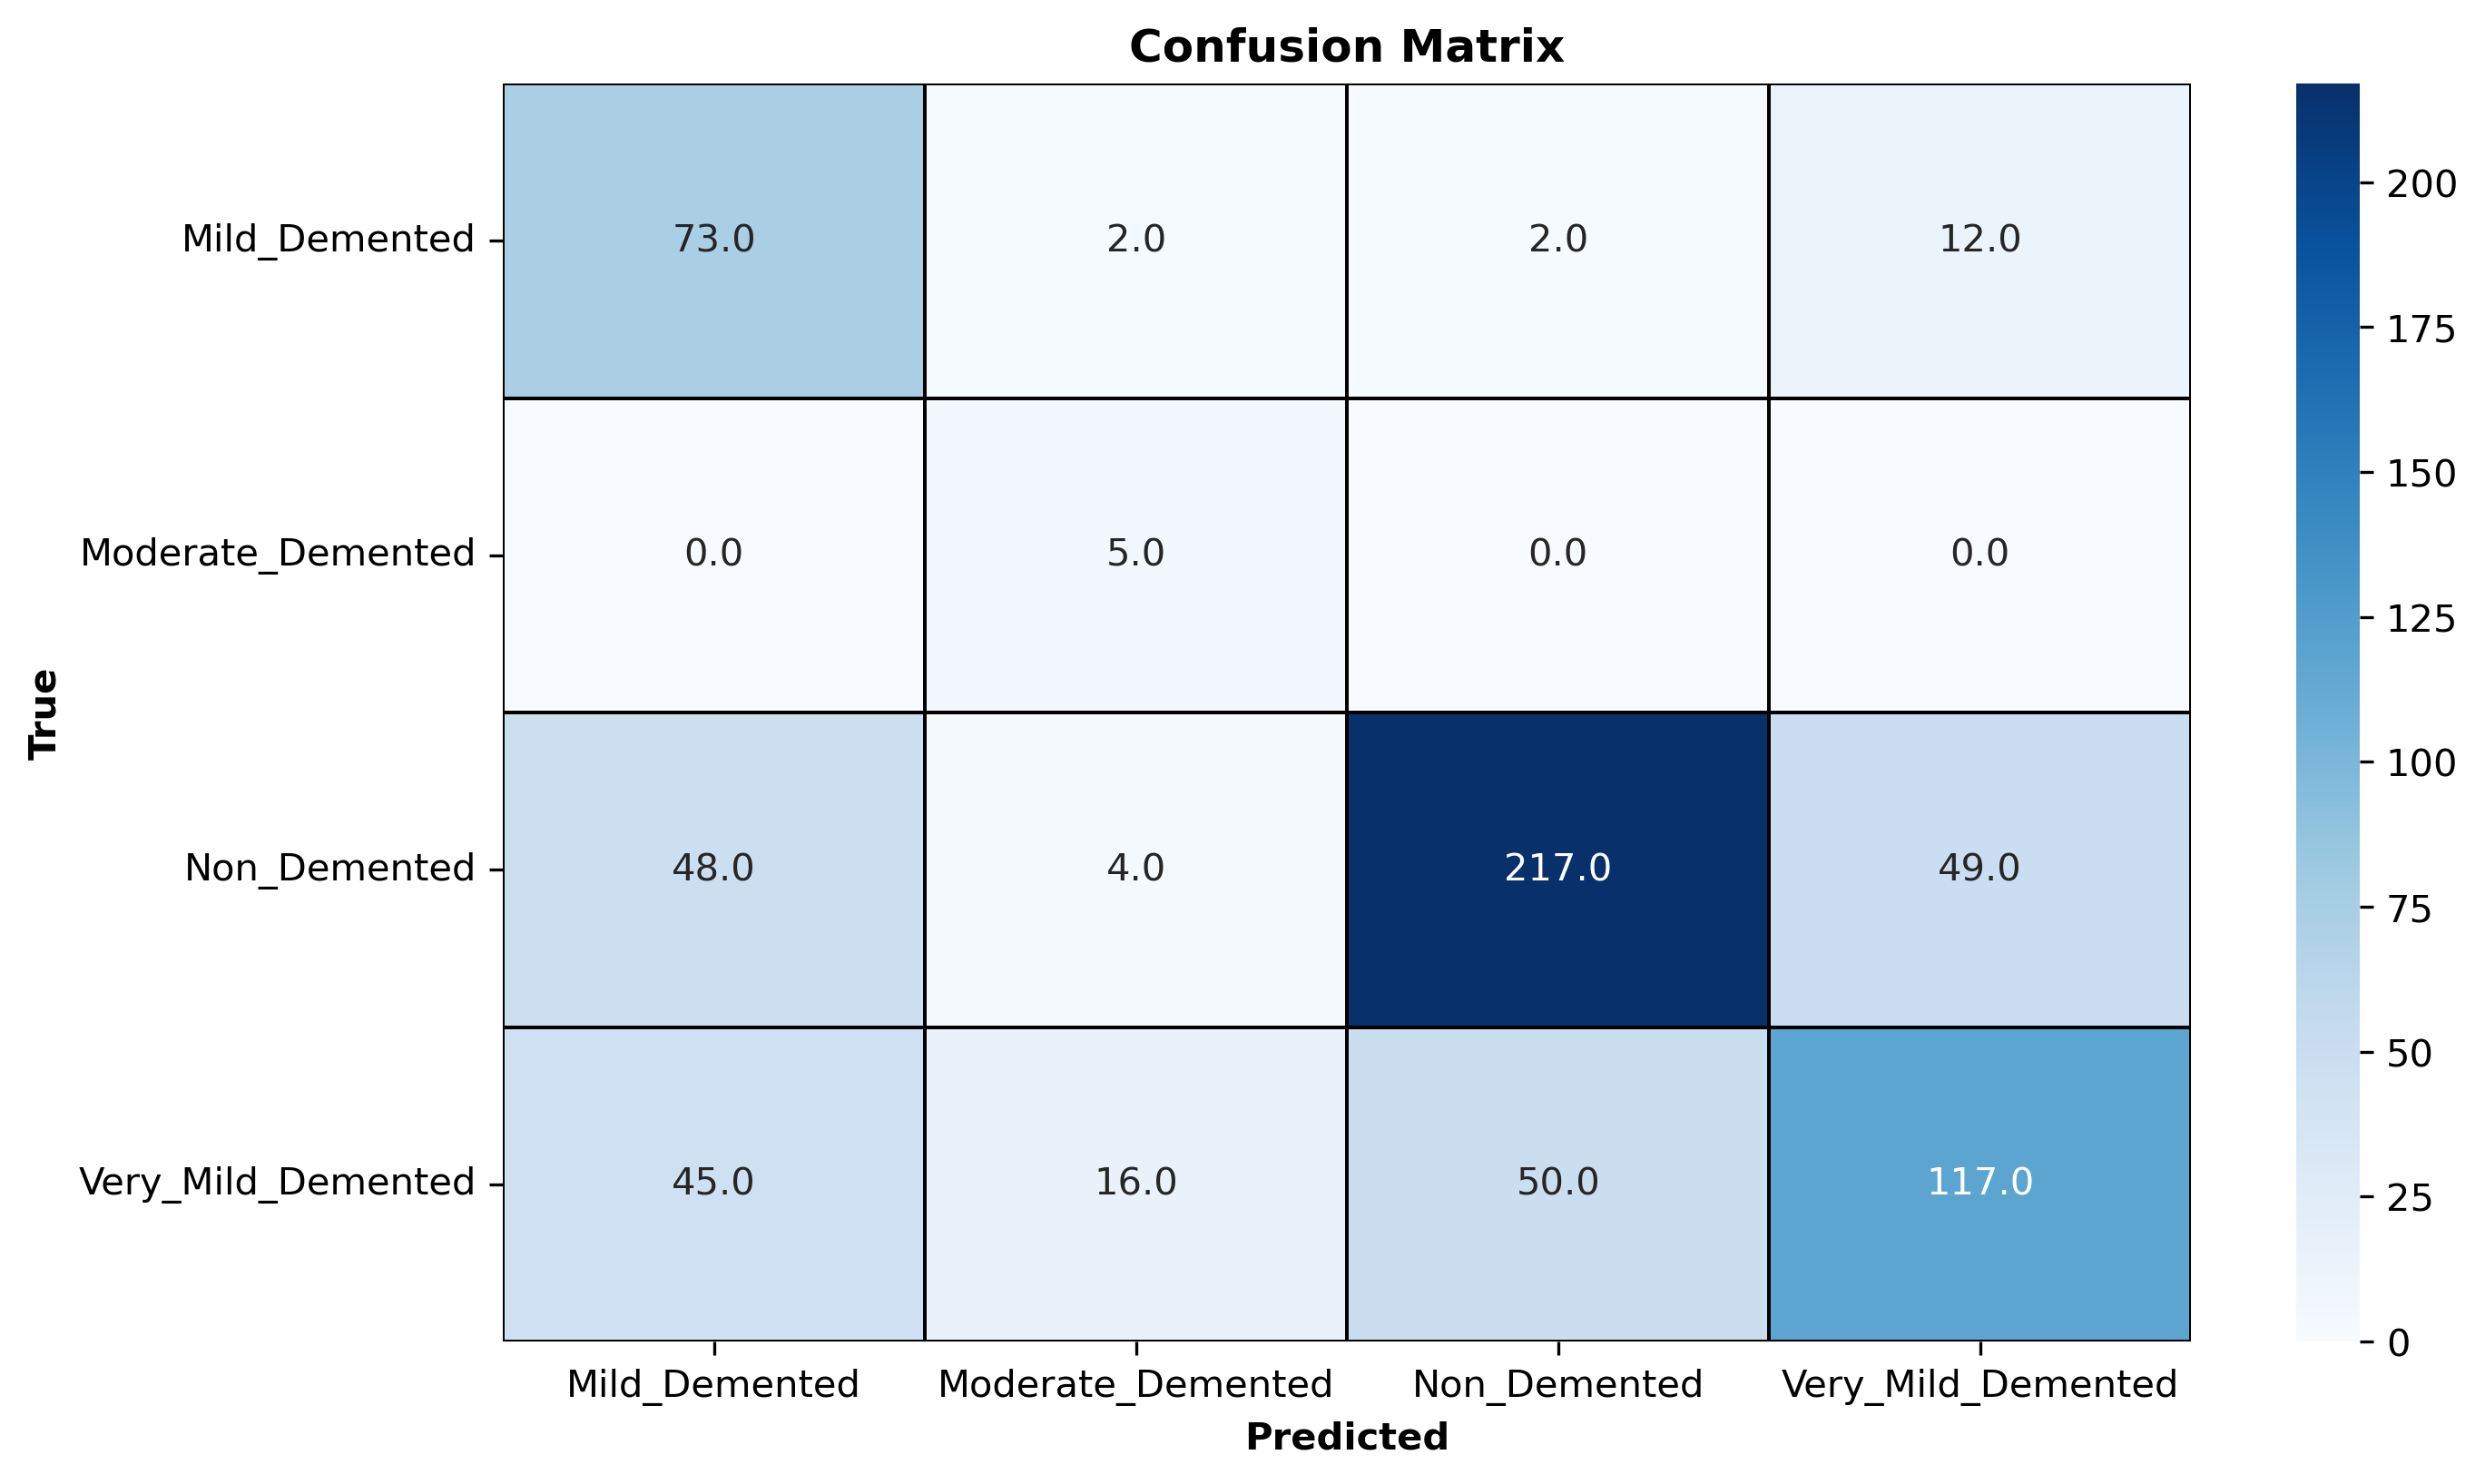

In [56]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f", linewidths=0.5, linecolor='black')

plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

plt.show()

In [77]:
cnn_model.save('cnn_model.keras')
resnet_model.save('resnet_model.keras')
vgg_model.save('vgg_model.keras')